# Document Classification Test (HeavyWater Machine Learning Challenge)
# Simple LSTM models

**Problem Statement**

We process documents related to mortgages, aka everything that happens to originate a mortgage that you don't see as a borrower. Often times the only access to a document we have is a scan of a fax of a print out of the document. Our system is able to read and comprehend that document, turning a PDF into structured business content that our customers can act on.

This dataset represents the output of the OCR stage of our data pipeline ...  Each word in the source is mapped to one unique value in the output. If the word appears in multiple documents then that value will appear multiple times. The word order for the dataset comes directly from our OCR layer, so it should be roughly in order.

**Mission**

Train a document classification model. Deploy your model to a public cloud platform (AWS/Google/Azure/Heroku) as a webservice, send us an email with the URL to you github repo, the URL of your publicly deployed service so we can submit test cases and a recorded screen cast demo of your solution's UI, its code and deployment steps. Also, we use AWS so we are partial to you using that ... just saying.

**Lightweight way to test for tensorflow detection of GPUs (with diagnostics), using command line:**

```python
python3 -c "from tensorflow.python.client import device_lib; print(device_lib.list_local_devices())"
```

## Setup

### Library import

We import all the required Python libraries

In [ ]:
from time import asctime, gmtime, localtime, perf_counter
print(asctime(localtime()))

t0 = perf_counter()

from collections import Counter, OrderedDict
import gc		# garbage collection module
import os
import pathlib
import pickle
from random import random
import sys

print("Python version: ", sys.version_info[:])
print("Un-versioned imports:\n")
prefixStr = ''
print(prefixStr + 'collections', end="  ")
print(prefixStr + 'gc', end="  ")
print(prefixStr + 'os', end="  ")
print(prefixStr + 'pathlib', end="  ")
print(prefixStr + 'pickle', end="  ")
print(prefixStr + 'random', end="  ")
print(prefixStr + 'sys', end="")

import re

from dateutil import __version__ as duVersion
from dateutil.parser import parse
import numpy as np

mdVersion = None
# from modin import __version__ as mdVersion
# import modin.pandas as pd
import pandas as pd
ppVersion = None

import graphviz

scVersion = None
from scipy import __version__ as scVersion
import scipy.sparse as sp

from sklearn import __version__ as skVersion
from sklearn.metrics import confusion_matrix, classification_report
# from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

tfVersion = None
from tensorflow import __version__ as tfVersion
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Input
from tensorflow.keras.layers import Dense, Embedding, Bidirectional, LSTM, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model as load
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
from tensorflow.python.client import device_lib 
from tensorflow import device
from tensorflow.keras.metrics import SparseCategoricalCrossentropy


tfaVersion = None
from tensorflow_addons import __version__ as tfaVersion
from tensorflow_addons.metrics import F1Score

# Visualizations

mpVersion = None
from matplotlib import __version__ as mpVersion
import matplotlib.pyplot as plt

import seaborn as sns
import colorcet as cc

print("\n")
print(f"colorcet: {cc.__version__}", end="\t")
print(f"dateutil: {duVersion}", end="\t")
print(f"graphviz: {duVersion}", end="\t")
print(f"matplotlib: {mpVersion}", end="\t")
if 'modin' in sys.modules:
    print(f"modin: {mdVersion}", end="\t")
print(f"numpy: {np.__version__}", end="\t")
if 'pandas' in sys.modules:
    print(f"pandas: {pd.__version__}", end="\t")
print(f"re: {re.__version__}", end="\t")
print(f"scipy: {scVersion}", end="\t")
print(f"seaborn: {sns.__version__}", end="\t")
print(f"sklearn: {skVersion}", end="\t")
print(f"tensorflow: {tfVersion}", end="\t")
print(f"tensorflow_addons: {tfaVersion}", end="\t")
print(f"xgboost: {xgbVersion}", end="\t")
# if '' in sys.modules:
#     print(f": {.__version__}", end="\t")
Δt = perf_counter() - t0
print(f"\n\nΔt: {Δt: 4.1f}s.")

print("\nlocal devices:\n\n", device_lib.list_local_devices())

%matplotlib inline

# Options for pandas
pd.options.display.max_columns = 30
pd.options.display.max_rows = 50

# Autoreload extension
if 'autoreload' not in get_ipython().extension_manager.loaded:
    %load_ext autoreload
    
%autoreload 2

### Local library import

We import all the required local libraries libraries

In [2]:
rootPath = pathlib.Path.cwd().parent
libPath = rootPath / 'python'

# Include local library paths
sys.path.append(str(libPath)) # uncomment and fill to import local libraries

# Import local libraries
from utility import ModelTrain as mt
from plotHelpers import plotHelpers as ph

**Next two lines are for pretty output for all prints in a Pandas cell, not just the last**

In [3]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

<a id="helper-tokenize"></a>
### Helper functions

#### `tokenize()`

In [4]:
help(Tokenizer)

Help on class Tokenizer in module keras_preprocessing.text:

class Tokenizer(builtins.object)
 |  Text tokenization utility class.
 |  
 |  This class allows to vectorize a text corpus, by turning each
 |  text into either a sequence of integers (each integer being the index
 |  of a token in a dictionary) or into a vector where the coefficient
 |  for each token could be binary, based on word count, based on tf-idf...
 |  
 |  # Arguments
 |      num_words: the maximum number of words to keep, based
 |          on word frequency. Only the most common `num_words-1` words will
 |          be kept.
 |      filters: a string where each element is a character that will be
 |          filtered from the texts. The default is all punctuation, plus
 |          tabs and line breaks, minus the `'` character.
 |      lower: boolean. Whether to convert the texts to lowercase.
 |      split: str. Separator for word splitting.
 |      char_level: if True, every character will be treated as a token.


In [5]:
def tokenize(corpus, vocabSz):
    """
    Generates the vocabulary and the list of list of integers for the input corpus

    Help from: https://www.tensorflow.org/tutorials/text/nmt_with_attention

    INPUTS:
        corpus: list, type(str), containing (short) document strings
        vocabSz: (int) Maximum number of words to consider in the vocabulary

    RETURNS: List of list of indices for each string in the corpus + Keras sentence tokenizer object

    Usage:
        listOfListsOfIndices, sentenceTokenizer = tokenize(mySentences, maxVocabCt)
    """

    # Define the sentence tokenizer
    tokenizer = Tokenizer(num_words=vocabSz,
    #                               filters='!#%()*+,./:;<=>?@[\\]^_`{|}~\t\n',
                                  filters='%',
                                  lower=False,
                                  split=' ', char_level=False, oov_token="<unkwn>")

    # Keep the double quote, dash, and single quote + & (different from word2vec training: didn't keep `&`)
    # oov_token: added to word_index & used to replace out-of-vocab words during text_to_sequence calls
    # num_words = maximum number of words to keep, dropping least frequent

    # Fit the tokenizer on the input corpus
    tokenizer.fit_on_texts(corpus)

    # Transform each text in corpus to a sequence of integers
    listOfIndexLists = tokenizer.texts_to_sequences(corpus)

    return listOfIndexLists, tokenizer

#### `recallK()`

In [6]:
def recallK(yTrue, yPred):
    truePositives = K.sum(K.round(K.clip(yTrue * yPred, 0, 1)))
    possiblePositives = K.sum(K.round(K.clip(yTrue, 0, 1)))
    recall = truePositives / (possiblePositives + K.epsilon())
    return recall

#### `precisionK()`

In [7]:
def precisionK(yTrue, yPred):
    truePositives = K.sum(K.round(K.clip(yTrue * yPred, 0, 1)))
    possiblePositives = K.sum(K.round(K.clip(yTrue, 0, 1)))
    recall = truePositives / (possiblePositives + K.epsilon())
    return recall

#### `f1K()`

In [8]:
def f1K(yTrue, yPred):
    truePositives = K.sum(K.round(K.clip(yTrue * yPred, 0, 1)))
    possiblePositives = K.sum(K.round(K.clip(yTrue, 0, 1)))
    recall = truePositives / (possiblePositives + K.epsilon())
    return recall

## Prepare Data

#### Define paths

In [9]:
dataPath = rootPath / 'data'
modelPath = rootPath / 'model'
plotPath = rootPath / 'figures'
checkpointPath = rootPath / 'checkpoints'
tensorBoardPath = rootPath / 'tensorBoardLogs'

### Import data

In [10]:
sourceData = dataPath / 'shuffled-full-set-hashed.csv.zip'
df0 = pd.read_csv(sourceData, header=None, names=['category', 'docText'])
df0.head()
df0.tail()

,category,docText
0,DELETION OF INTEREST,e04a09c87692 d6b72e591b91 5d066f0246f1 ed41171...
1,RETURNED CHECK,a3b334c6eefd be95012ebf2b 41d67080e078 ff1c26e...
2,BILL,586242498a88 9ccf259ca087 54709b24b45f 6bf9c0c...
3,BILL,cd50e861f48b 6ca2dd348663 d38820625542 f077614...
4,BILL,9db5536263d8 1c303d15eb65 3f89b4673455 b73e657...


,category,docText
62199,CANCELLATION NOTICE,6bf9c0cb01b4 52102c70348d 1b6d0614f2c7 246ee0c...
62200,BINDER,816aed74475e 288ccf089872 fe33912c5732 5d00ab6...
62201,BILL,f95d0bea231b 894305951372 c9a53ea6e219 8f6018d...
62202,CANCELLATION NOTICE,5ee06767bc0f 106de4332a24 46a0c35e916c 54709b2...
62203,CANCELLATION NOTICE,586242498a88 21e314d3afcc 818a7ff3bf29 4e43b72...


### Munge/inspect data

**There are 45 null documents**

In [11]:
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62204 entries, 0 to 62203
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  62204 non-null  object
 1   docText   62159 non-null  object
dtypes: object(2)
memory usage: 972.1+ KB


**How distributed?**

In [12]:
df0[df0.docText.isna()].groupby(by='category').size()

category
BILL                     9
BINDER                  21
CANCELLATION NOTICE      2
DECLARATION              1
POLICY CHANGE           11
REINSTATEMENT NOTICE     1
dtype: int64

**Have a look at some empty documents**

Yep, line numbers correspond to locations in .csv file.

In [13]:
df0[df0.docText.isna()].head(6)

,category,docText
835,BINDER,NaN
2572,POLICY CHANGE,NaN
2579,BINDER,NaN
3482,BINDER,NaN
5019,BINDER,NaN
5748,BINDER,NaN


**There are 14 document categories**

In [14]:
categories = df0.category.unique()
len(categories)
print(categories)

14

['DELETION OF INTEREST' 'RETURNED CHECK' 'BILL' 'POLICY CHANGE'
 'CANCELLATION NOTICE' 'DECLARATION' 'CHANGE ENDORSEMENT'
 'NON-RENEWAL NOTICE' 'BINDER' 'REINSTATEMENT NOTICE' 'EXPIRATION NOTICE'
 'INTENT TO CANCEL NOTICE' 'APPLICATION' 'BILL BINDER']


#### Extract tokens (in order to get document lengths)

In [15]:
df0['tokens'] = df0.docText.apply(lambda p: [] if isinstance(p, float) else p.split())
df0.head()

,category,docText,tokens
0,DELETION OF INTEREST,e04a09c87692 d6b72e591b91 5d066f0246f1 ed41171...,"[e04a09c87692, d6b72e591b91, 5d066f0246f1, ed4..."
1,RETURNED CHECK,a3b334c6eefd be95012ebf2b 41d67080e078 ff1c26e...,"[a3b334c6eefd, be95012ebf2b, 41d67080e078, ff1..."
2,BILL,586242498a88 9ccf259ca087 54709b24b45f 6bf9c0c...,"[586242498a88, 9ccf259ca087, 54709b24b45f, 6bf..."
3,BILL,cd50e861f48b 6ca2dd348663 d38820625542 f077614...,"[cd50e861f48b, 6ca2dd348663, d38820625542, f07..."
4,BILL,9db5536263d8 1c303d15eb65 3f89b4673455 b73e657...,"[9db5536263d8, 1c303d15eb65, 3f89b4673455, b73..."


#### Get token counts

In [16]:
df0['docLength'] = df0.tokens.apply(lambda t: len(t))
df0.head()

,category,docText,tokens,docLength
0,DELETION OF INTEREST,e04a09c87692 d6b72e591b91 5d066f0246f1 ed41171...,"[e04a09c87692, d6b72e591b91, 5d066f0246f1, ed4...",465
1,RETURNED CHECK,a3b334c6eefd be95012ebf2b 41d67080e078 ff1c26e...,"[a3b334c6eefd, be95012ebf2b, 41d67080e078, ff1...",403
2,BILL,586242498a88 9ccf259ca087 54709b24b45f 6bf9c0c...,"[586242498a88, 9ccf259ca087, 54709b24b45f, 6bf...",185
3,BILL,cd50e861f48b 6ca2dd348663 d38820625542 f077614...,"[cd50e861f48b, 6ca2dd348663, d38820625542, f07...",337
4,BILL,9db5536263d8 1c303d15eb65 3f89b4673455 b73e657...,"[9db5536263d8, 1c303d15eb65, 3f89b4673455, b73...",546


## Pre-process data

### Test-train split

* remove documents of length < <font color="darkred">**6**</font>:
  * these are unlikely to be informative, and probably are result of scan error
  * probably should have these labeled as an error, for human review, rather than risk downstream adoption
* class imbalance spanning almost 2 orders of magnitude ⟶ *stratified sampling*
* smallest classes 229 instances, so need half to test with ~10% uncertainty
* after model selection, can train on entire data set

In [18]:
df = df0.copy()[df0.docLength > 5]
df0.shape, df.shape

((62204, 4), (62112, 4))

In [19]:
randomState = np.random.RandomState(11)

dfTr, dfTe = train_test_split(df, test_size=0.5, shuffle=True,
                              random_state=randomState, stratify=df.category)
dfTr.shape, dfTe.shape
dfTr.head()
dfTe.head()

((31056, 4), (31056, 4))

,category,docText,tokens,docLength
30571,RETURNED CHECK,776d8e8eda28 9d9120c02975 ce015f48ae93 52152b0...,"[776d8e8eda28, 9d9120c02975, ce015f48ae93, 521...",323
59800,BILL,25c57acdf805 a3df59e68df2 a845e8e2dbe6 aa1ef5f...,"[25c57acdf805, a3df59e68df2, a845e8e2dbe6, aa1...",191
46960,POLICY CHANGE,eb51798a89e1 08afcb631448 72bd4a50cf4a 1068682...,"[eb51798a89e1, 08afcb631448, 72bd4a50cf4a, 106...",482
3576,BINDER,bf3aa3fc66f6 7e07ecc160fd e1b9e4df3a88 769e648...,"[bf3aa3fc66f6, 7e07ecc160fd, e1b9e4df3a88, 769...",256
4376,BILL,25c57acdf805 2a49f4793e03 6ce6cc5a3203 dee46d3...,"[25c57acdf805, 2a49f4793e03, 6ce6cc5a3203, dee...",283


,category,docText,tokens,docLength
3351,DECLARATION,a0c020166d79 133d46f7ed38 fe64d3cdfe5b 36e7aa7...,"[a0c020166d79, 133d46f7ed38, fe64d3cdfe5b, 36e...",675
38868,BINDER,d9ef68daef4c 04503bc22789 afb1e3806fc1 e7e059c...,"[d9ef68daef4c, 04503bc22789, afb1e3806fc1, e7e...",275
21988,CHANGE ENDORSEMENT,5e99d31d8fa4 b99d622bf8e3 ecb0dd7353a4 816a114...,"[5e99d31d8fa4, b99d622bf8e3, ecb0dd7353a4, 816...",110
57907,BILL,3572a5c01503 21ab107e9310 a1fde4983c10 8ba05d1...,"[3572a5c01503, 21ab107e9310, a1fde4983c10, 8ba...",251
49746,BINDER,33a62c972b6f c4f716054f25 93202e5da9ab ba02159...,"[33a62c972b6f, c4f716054f25, 93202e5da9ab, ba0...",368


### Create list of lists of word indices, and TensorFlow sentence tokenizer object

Use strings from `dfTrain` to create vocabulary indices.

See [helper function `tokenize()`](#helper-tokenize)

* Each token is 12 characters long, so minimum string length is 6 &times; 12 + 5 (spaces) = 77

<a id="maxvocabct"></a>
Must specify a limit to the number of unique tokens for the tokenizer.
(Changing this will require re-instantiating it.)

* `maxVocabCt`			vocabulary size to be returned by tokenizer, dropping least frequent

Other parameters are defined below in [LSTM 0, baseline model parameters](#lstm0-parameters), and similarly for subsequent models.

Tokenizing takes ~10 s.

In [17]:
maxVocabCt = 100_000

In [20]:
df.docText.str.len().min()
ListOfDocsTr = list(dfTr.docText)
listOfListsOfWordIndicesTr, tokenizer = tokenize(ListOfDocsTr, maxVocabCt)

77

### Compute weights for each class

#### `dfTr` category breakdowns

* categoriesBySupport are category names ordered by support in `dfTr`

In [21]:
categoryCts = dfTr[['category', 'docLength']].groupby(by='category').count()\
    .rename(columns={'docLength': 'count'})
categoryCts

categoryCts.sort_values(by='count', ascending=False)
categoriesBySupport = list(categoryCts.sort_values(by='count', ascending=False).index)
categoriesBySupport

,count
category,
APPLICATION,114
BILL,9475
BILL BINDER,144
BINDER,4469
CANCELLATION NOTICE,4864
CHANGE ENDORSEMENT,445
DECLARATION,483
DELETION OF INTEREST,2413
EXPIRATION NOTICE,367


,count
category,
BILL,9475
POLICY CHANGE,5297
CANCELLATION NOTICE,4864
BINDER,4469
DELETION OF INTEREST,2413
REINSTATEMENT NOTICE,2184
DECLARATION,483
CHANGE ENDORSEMENT,445
RETURNED CHECK,375


['BILL',
 'POLICY CHANGE',
 'CANCELLATION NOTICE',
 'BINDER',
 'DELETION OF INTEREST',
 'REINSTATEMENT NOTICE',
 'DECLARATION',
 'CHANGE ENDORSEMENT',
 'RETURNED CHECK',
 'EXPIRATION NOTICE',
 'NON-RENEWAL NOTICE',
 'BILL BINDER',
 'APPLICATION',
 'INTENT TO CANCEL NOTICE']

#### Extract training and test labels

In [22]:
categoryInds = {c: i for c, i in zip(categoriesBySupport, range(len(categories)))}

yTr = dfTr.category.apply(lambda c: categoryInds[c])
yTe = dfTe.category.apply(lambda c: categoryInds[c])
yTr.head()
yTr.tail()

30571    8
59800    0
46960    1
3576     3
4376     0
Name: category, dtype: int64

50767    10
57781     5
58144     3
1313      0
16969     5
Name: category, dtype: int64

#### Determine class weights

In [23]:
weights = class_weight.compute_class_weight('balanced',
                                            range(len(categories)),
                                            yTr)
print(weights)
classWeights = {i: weights[i] for i in range(len(categories))}
print("classWeights:\n", classWeights)

[ 0.23411986  0.41878152  0.45606203  0.49637183  0.91930614  1.01569859
  4.59272405  4.98491172  5.91542857  6.04437524  7.10989011 15.4047619
 19.45864662 19.45864662]
classWeights:
 {0: 0.2341198643045609, 1: 0.41878152053723133, 2: 0.456062030075188, 3: 0.4963718313460985, 4: 0.9193061393641584, 5: 1.0156985871271587, 6: 4.592724046140195, 7: 4.984911717495987, 8: 5.9154285714285715, 9: 6.044375243285325, 10: 7.1098901098901095, 11: 15.404761904761905, 12: 19.458646616541355, 13: 19.458646616541355}


## LSTM Models

<!-- #### `f1_scorer`: grid search optimize for $f_1$ *f*<sub>1</sub> -->

In [24]:
# f1_scorer = make_scorer(f1_score, average='weighted')

<a id="define-model0"></a>
### Define model0

* embedding layer
* bidirectional LSTM
* dense layer (relu)
* dense layer (relu)
* classifier dense layer (softmax)

In [25]:
def model0(sequenceLength, vocabSz, classCt, LSTMinternalLayerSz,
           embedLayerDim, densLayerDim=64, softMaxCt=16, dropoutFrac=0.15,
           LSTMdropoutFrac=0.40):

    """
    INPUTS:
    sequenceLength			int, number of LSTM units
    vocabSz					int, size of vocabulary
    LSTMinternalLayerSz		int, size of layers within LSTM units
    embedLayerDim			int, dimension of embedding layer
    densLayerDim			int, dimension of dense layers, default: 64
    softMaxCt				int, dimension of softmax output, default: 16
    dropoutFrac				int, dropout rate, default: 0.15
    LSTMdropoutFrac			int, dropout rate for LSTMs, default: 0.40
    """

    # Headline input: meant to receive sequences of *sequenceLength* integers, between 1 and *vocabSz*.
    # Note that we can name any layer by passing it a "name" argument.
    mainInput = Input(shape=(sequenceLength,), dtype='int32', name='MainInput')

    # This embedding layer will encode the input sequence
    # into a sequence of dense 64-dimensional vectors.
    x = Embedding(input_length=sequenceLength, input_dim=vocabSz,
                  output_dim=embedLayerDim, trainable=True, name="EmbedLayer")(mainInput)

    # A LSTM will transform the vector sequence into a single vector,
    # containing information about the entire sequence
    LSTMout0 = Bidirectional(LSTM(LSTMinternalLayerSz,
                                  dropout=dropoutFrac,
                                  recurrent_dropout=LSTMdropoutFrac,
    #                             return_sequences=True),		# True, if followed by another LSTM layer
                                  return_sequences=False),		# False if followed by dense layer
                                  name='BidrectionalLSTM')(x)
    # LSTMout1 = LSTM(LSTMinternalLayerSz,
    #                 dropout=dropoutFrac,
    #                 recurrent_dropout=LSTMdropoutFrac)(LSTMout0)

    # auxiliaryInput = Input(shape=(auxFeatureCount,), name='numericalInput')
    # x = concatenate([LSTMout1, auxiliaryInput])

    # We stack a deep densely-connected network on top
    # x = Dense(densLayerDim, activation='relu')(x)
    x = Dense(densLayerDim, activation='relu', name='Dense0')(LSTMout0)
    x = Dense(densLayerDim, activation='relu', name='Dense1')(x)

    # And finally we add the main logistic regression layer
    mainOutput = Dense(classCt, activation='softmax', name='MainOutput')(x)
    # model = Model(inputs=[main_input, auxiliaryInput], outputs=mainOutput)
    model = Model(inputs=mainInput, outputs=mainOutput)

    return model

<a id="tokenize-64-tokens"></a>
### LSTM 0 & LSTM 1 tokenize

* truncate docs to `maxDocWords = 64` tokens
* pre-pad shorter docs with 0s

##### Tensor of word indices for train

In [26]:
padValue = 0
maxDocWords = 64

XdocsTr = pad_sequences(listOfListsOfWordIndicesTr,
                        maxlen=maxDocWords,
                        dtype='int32', padding='pre',
                        truncating='post', value=padValue)

In [27]:
ListOfDocsTr[0]
print(listOfListsOfWordIndicesTr[0])
XdocsTr[0]

'776d8e8eda28 9d9120c02975 ce015f48ae93 52152b0093a1 5cf416836ddd 21d06acb5c5a 82c32a96c28a fc25f79e6d18 4ef731a80c24 758684f862e4 688c4bbfca80 9e2b31af60e1 c29f0593f229 9c58ed44374f 635ad16e1001 6e2c9c88b447 6ce6cc5a3203 c85b3821556b 89aed7fbfb0e 2e85d01c5d75 e7f10ad56136 2053a6a9efee fb1a3ce496b1 26f768da5068 0a8965c4b8f4 6af770640118 11610fcf8c49 f2b0e028fe2c 72bd4a50cf4a 54709b24b45f 823c39d495d0 6af770640118 6b304aabdcee 335e39009eab cf8a124d4e59 cb7631b88e51 304a68728141 97b6014f9e50 26f768da5068 6af770640118 e137a75c0b90 d5f4611022c1 46c88d9303da d63be9e66da8 4d134e3d5af5 f95d0bea231b 6ce6cc5a3203 6365c4563bd1 6df520735456 6365c4563bd1 6e34c0d3d1aa 6365c4563bd1 46c88d9303da 6365c4563bd1 6365c4563bd1 ff8452befa25 3593bd452331 81dc2e5c1272 d78dc767a475 3689f1b1fc46 ccef80e38b2b f6f466726339 39d83a0aee75 ab399ebcc0fe b9925442c9c9 07b4174549d4 395a5e8185f8 bc5e0615b2da 32f49d072772 53d94d11f6bb 8565203321d4 93977e7acdcf 93790ade6682 eb51798a89e1 9bc65adc033c 97b6014f9e50 26f768da506

[673, 8480, 1911, 1, 29094, 1, 33264, 157, 1395, 399, 6626, 33265, 1, 20636, 4438, 5594, 4, 214, 1327, 73, 204, 17094, 4687, 36, 1, 32, 1, 224, 182, 12, 42966, 32, 21, 10648, 1, 256, 1, 23, 36, 32, 407, 184, 52, 299, 33266, 17, 4, 49, 226, 49, 22415, 49, 52, 49, 49, 943, 1411, 29095, 648, 350, 1, 369, 79132, 726, 723, 568, 265, 4916, 1308, 1, 47871, 1, 44, 63, 33, 23, 36, 32, 36, 7511, 1, 19, 530, 753, 2829, 878, 5595, 21, 35843, 3240, 1170, 73, 153, 9140, 54, 935, 11657, 8722, 1, 2550, 299, 673, 1333, 1, 655, 17095, 5972, 407, 42, 130, 867, 1695, 53, 250, 380, 7, 175, 867, 27, 146, 42, 22416, 1, 3284, 21, 12, 5230, 27, 1, 8481, 1, 31, 177, 655, 42967, 1, 51, 218, 15, 1385, 402, 381, 1, 101, 42, 1, 407, 655, 73, 1, 21, 52, 1029, 17, 6, 326, 122, 577, 5654, 19, 232, 15, 183, 110, 233, 15, 90, 44, 188, 41, 1, 47, 100, 8, 33, 57, 38, 49, 5509, 225, 33, 136, 78, 19, 232, 15, 77, 142, 4500, 39, 655, 82, 34, 25942, 12698, 418, 5509, 225, 12229, 51, 218, 14, 901, 74, 54732, 2, 1199, 67, 12698

array([  673,  8480,  1911,     1, 29094,     1, 33264,   157,  1395,
         399,  6626, 33265,     1, 20636,  4438,  5594,     4,   214,
        1327,    73,   204, 17094,  4687,    36,     1,    32,     1,
         224,   182,    12, 42966,    32,    21, 10648,     1,   256,
           1,    23,    36,    32,   407,   184,    52,   299, 33266,
          17,     4,    49,   226,    49, 22415,    49,    52,    49,
          49,   943,  1411, 29095,   648,   350,     1,   369, 79132,
         726], dtype=int32)

##### Tensor of word indices for test

In [28]:
ListOfDocsTe = list(dfTe.docText)
listOfListsOfWordIndicesTe = tokenizer.texts_to_sequences(ListOfDocsTe)
XdocsTe = pad_sequences(listOfListsOfWordIndicesTe,
                        maxlen=maxDocWords,
                        dtype='int32', padding='pre',
                        truncating='post', value=padValue)

In [29]:
ListOfDocsTe[0]
print(listOfListsOfWordIndicesTe[0])
XdocsTe[0]

'a0c020166d79 133d46f7ed38 fe64d3cdfe5b 36e7aa72ffe1 7a5e719bafba fafeb212675a ff1c26ea0b6f 93c988b67c47 0562c756a2f2 07e7fe209a3b ff714b9fa7fd fe64d3cdfe5b c9a53ea6e219 993ff2804aa9 cbd6e2e7a804 e4c167e314c2 1851758c92b2 e259a56993f4 e94953618947 c79b01c5629d 6ce6cc5a3203 094e2de7e1cd 4ba791167817 9bfc4c4973a6 82204d3e715e 5dc7c49eb85d 2ed97f462806 a51c4e06df28 db3176de6e95 21e314d3afcc 2ee5e18ba524 586242498a88 360e8b28421c df7b799d2534 4a68a8674193 0f88ca127938 9a1d3ab82b96 1e5c095af1d7 71144e880c8d 7d9e333a86da ab876af5ae0b faaa1c06b512 21e314d3afcc e6dbab0cbfb4 5892ad716bb7 d493c688fb66 4ffb12504ac6 e9b0e655984e 347a5d991fe1 0a9b859f7b89 9e851f85cce7 4895c4bdb608 1015893e384a 8f7a92cd0ae7 21e314d3afcc 40fbee1e4d5c 1068682ce752 415fc0f6a895 586242498a88 ac6bf0e47705 21e314d3afcc 09b305bd6c36 664aa24ff74f 427028e08976 11269ab19093 21e314d3afcc becb9d433d2c 327f094890d6 1669ab06727a a263b63bc282 97b6014f9e50 b01c6237ae4a a9ee836e8303 e259a56993f4 ba8f19d976a8 133d46f7ed38 0c4ce226d9f

[71, 9, 118, 53, 209, 8795, 269, 171, 19, 808, 249, 118, 83, 1, 178, 2313, 1188, 135, 232, 218, 4, 1261, 301, 291, 1240, 3305, 372, 1, 1307, 6, 30555, 2, 97, 1037, 647, 286, 707, 4109, 465, 20, 1, 13429, 6, 1233, 366, 125, 128, 7828, 490, 1268, 2177, 7720, 8, 132, 6, 872, 29, 1574, 2, 825, 6, 549, 559, 231, 261, 6, 6289, 579, 244, 574, 23, 1104, 163, 135, 101, 9, 78, 8795, 174, 31526, 1093, 357, 30, 135, 9, 109, 184, 370, 465, 17995, 8790, 787, 6, 218, 1788, 1, 1759, 1991, 266, 787, 2179, 228, 2278, 30, 2201, 494, 2338, 86, 662, 816, 72, 922, 1037, 286, 291, 3305, 4, 3, 165, 1, 353, 23, 367, 8795, 9, 3690, 19, 283, 73, 266, 3, 3283, 122, 165, 209, 269, 2313, 1, 1, 119, 28820, 171, 180, 3, 4165, 80, 9855, 1261, 19, 688, 6, 218, 2, 412, 132, 8795, 16, 19, 78, 132, 871, 78, 132, 14, 1718, 6850, 18129, 208, 37, 943, 1, 4736, 195, 120, 464, 53, 8795, 197, 229, 90, 233, 6, 835, 835, 340, 56, 370, 2, 257, 8, 8795, 2, 149, 13929, 505, 27, 84, 19, 158, 15, 190, 457, 1431, 2378, 409, 743, 3321, 

array([   71,     9,   118,    53,   209,  8795,   269,   171,    19,
         808,   249,   118,    83,     1,   178,  2313,  1188,   135,
         232,   218,     4,  1261,   301,   291,  1240,  3305,   372,
           1,  1307,     6, 30555,     2,    97,  1037,   647,   286,
         707,  4109,   465,    20,     1, 13429,     6,  1233,   366,
         125,   128,  7828,   490,  1268,  2177,  7720,     8,   132,
           6,   872,    29,  1574,     2,   825,     6,   549,   559,
         231], dtype=int32)

<a id="lstm0-parameters"></a>
### LSTM 0

#### baseline model parameters

* Bidirectional(LSTM) only
* `LSTMlayerUnits = 64`
* `maxDocWords = 64`


Settings are minimal, so that basic functioning of configuration can be tested relatively quickly.

Refer to the [LSTM 0 & LSTM 1 tokenize](#tokenize-64-tokens) section for the size of `maxVocabCt`.

|parameter|&nbsp;&nbsp;|description|
|:--------|------------|:----------|
|`testFrac`||fraction of data set withheld|
|`LSTMlayerUnits`||# units within each activation unit in LSTMs|
|`embeddingDim'||size of dimension for generated embeddings|
|`auxFeaturesCt`||# of features in auxiliary data|
|`classCt`||# classes (softmax output dim)|
|`dropoutFrac`||dropout fraction|
|`LSTMdropoutFrac`||dropout fraction within LSTMs|
|`batchSz`||size of batches|
|`epochCt`||number of epochs to run|

In [30]:
testFrac = 0.5
LSTMlayerUnits = 64
embeddingDim = 64
classCt = len(categoriesBySupport)
dropoutFrac = 0.15
LSTMdropoutFrac = 0.5
# LSTMdropoutFrac = 0			# Must be 0 for use of cudnn
batchSz = 64
epochCt = 30

#### LSTM 0 callbacks

* checkpoints
* TensorBoard
* (no early stopping)

In [31]:
modelInstanceDir = (f"vocabCt{maxVocabCt:06d}maxCommentLen{maxDocWords:03d}"
                    + f"classCt{classCt:02d}"
                    + f"embedDim{embeddingDim:03d}"
                    + f"LSTMlayerSz{LSTMlayerUnits:03d}batchSz{batchSz:03d}"
                    + f"dropoutFrac{dropoutFrac:4.2f}"
                    + f"LSTMdropoutFrac{dropoutFrac:4.2f}")
print(modelInstanceDir, "\n")

checkpointPrefix = os.path.join(checkpointPath, modelInstanceDir,
                                "ckpt{epoch:03d}")
print(checkpointPrefix, "\n")

checkpointCallback=ModelCheckpoint(filepath=checkpointPrefix,
                                   save_weights_only=True)
os.makedirs(tensorBoardPath, exist_ok=True)                       

logsDir = os.path.join(tensorBoardPath, modelInstanceDir)
print(logsDir, "\n")

os.makedirs(logsDir, exist_ok=True)
tensorboardCallback = TensorBoard(log_dir=logsDir, histogram_freq=1)

vocabCt100000maxCommentLen064classCt14embedDim064LSTMlayerSz064batchSz064dropoutFrac0.15LSTMdropoutFrac0.15 

/home/mark/work/document-classification-test/checkpoints/vocabCt100000maxCommentLen064classCt14embedDim064LSTMlayerSz064batchSz064dropoutFrac0.15LSTMdropoutFrac0.15/ckpt{epoch:03d} 

/home/mark/work/document-classification-test/tensorBoardLogs/vocabCt100000maxCommentLen064classCt14embedDim064LSTMlayerSz064batchSz064dropoutFrac0.15LSTMdropoutFrac0.15 



#### Load or instantiate LSTM 0

In [32]:
print(asctime(gmtime()))
LSTM0name = 'LSTM0'

if (modelPath / LSTM0name).is_file():
    print(f"Loading {LSTM0name} model from disk.")
    LSTM0 = load(modelPath / LSTM0name)
else:
    np.random.seed(0)  # Set a random seed for reproducibility

    print("Instantiate LSTM 0, using model0 ...")
    with device('/device:GPU:1'):
        LSTM0 = model0(maxDocWords, maxVocabCt, classCt, LSTMlayerUnits,
                       embeddingDim, softMaxCt=classCt)
    LSTM0.summary()

Tue Jan 26 17:08:48 2021
Instantiate LSTM 0, using model0 ...
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
MainInput (InputLayer)       [(None, 64)]              0         
_________________________________________________________________
EmbedLayer (Embedding)       (None, 64, 64)            6400000   
_________________________________________________________________
BidrectionalLSTM (Bidirectio (None, 128)               66048     
_________________________________________________________________
Dense0 (Dense)               (None, 64)                8256      
_________________________________________________________________
Dense1 (Dense)               (None, 64)                4160      
_________________________________________________________________
MainOutput (Dense)           (None, 14)                910       
Total params: 6,479,374
Trainable params: 6,479,374
Non-trainable

<a id="model0-graph"></a>
#### Model 0 graph

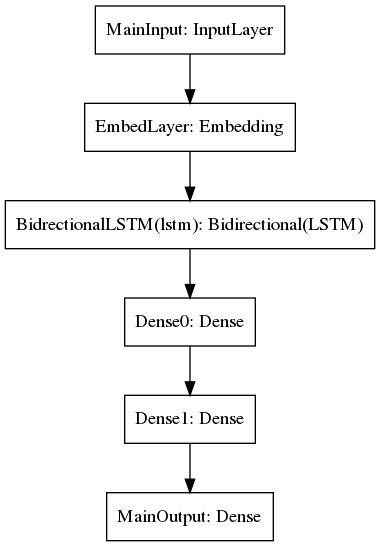

In [33]:
plot_model(LSTM0, to_file=os.path.join(plotPath, 'model0graph.png'))

#### Compile LSTM 0

In [34]:
if not (modelPath / LSTM0name).is_file():
    with device('/device:GPU:1'):
        LSTM0.compile(optimizer='rmsprop',
                      loss='sparse_categorical_crossentropy',
                      metrics = 'accuracy') 
                      # metrics = ['accuracy', Recall(), Precision(),
                      #            F1Score(num_classes=classCt),
                      #            SparseCategoricalCrossentropy(from_logits=False)])

<a id="train-lstm0"></a>
#### Train LSTM 0

In [35]:
if not (modelPath / LSTM0name).is_file():
    print(epochCt, batchSz)
    print(classWeights)
    with device('/device:GPU:1'):
        history0 = LSTM0.fit(x=XdocsTr,
                             y= yTr.values,
                             epochs=epochCt, batch_size=batchSz,
                             shuffle=True,
                             class_weight=classWeights,
                             validation_split=0.2,
                             callbacks=[checkpointCallback, tensorboardCallback],
                             verbose=1)

30 64
{0: 0.2341198643045609, 1: 0.41878152053723133, 2: 0.456062030075188, 3: 0.4963718313460985, 4: 0.9193061393641584, 5: 1.0156985871271587, 6: 4.592724046140195, 7: 4.984911717495987, 8: 5.9154285714285715, 9: 6.044375243285325, 10: 7.1098901098901095, 11: 15.404761904761905, 12: 19.458646616541355, 13: 19.458646616541355}
Epoch 1/30
389/389 [==============================] - 126s 314ms/step - loss: 2.3205 - accuracy: 0.2927 - val_loss: 1.2411 - val_accuracy: 0.6505
Epoch 2/30
389/389 [==============================] - 119s 305ms/step - loss: 1.4515 - accuracy: 0.6025 - val_loss: 1.1367 - val_accuracy: 0.6568
Epoch 3/30
389/389 [==============================] - 118s 304ms/step - loss: 1.1238 - accuracy: 0.6765 - val_loss: 1.0741 - val_accuracy: 0.6718
Epoch 4/30
389/389 [==============================] - 118s 304ms/step - loss: 0.9952 - accuracy: 0.7053 - val_loss: 1.0621 - val_accuracy: 0.6853
Epoch 5/30
389/389 [==============================] - 118s 304ms/step - loss: 0.8443 -

#### Save LSTM 0, if new model

In [36]:
if not (modelPath / LSTM0name).is_file():
    print(f"Saving {LSTM0name} to disk.")
    LSTM0.save(modelPath / LSTM0name)

Saving LSTM0 to disk.
INFO:tensorflow:Assets written to: /home/mark/work/document-classification-test/model/LSTM0/assets


#### LSTM 0 inference on test data

In [37]:
softmaxOut = LSTM0.predict(x=XdocsTe)
yPred = np.argmax(softmaxOut, axis=1)

In [39]:
confusionMat = confusion_matrix(yTe, yPred)
print(confusionMat)

[[7267  292  414  459    4  172  433   22   66   62    4  210   15   55]
 [ 221 3183   79  653   13  143  512  233   50   31   22  118   27   12]
 [ 374   83 3400   47  194  336  223   31    6   45   60    9    3   54]
 [ 132  387   20 3230    1   21  494   16   46    8    2   91   18    3]
 [  11   22  312    7 1607   45  379    5    3    2    4    2    1   13]
 [  60   42  146   15    9 1806   61   13    6    6    2    1    0   16]
 [  61   76   25  168    7   11  104    9    5    1    3    7    4    2]
 [   3   70    7   12    2    8   13  324    2    0    1    1    0    1]
 [  20   16    4   35    0    3   12    2  271    0    1    8    2    0]
 [  46   16   30    4    1   11   22    7    0  217    8    1    0    4]
 [   3   11   40    2    1    6   15    8    0   13  210    1    0    2]
 [  36   17    1   36    0    0   10    1    2    2    1   37    1    0]
 [   8   22    1   39    0    0   12    1    2    3    0    9   18    0]
 [  16    7   26    3    0    5    6    0    0    2

In [40]:
accuracy = np.trace(confusionMat)/np.sum(confusionMat)
recall = np.diag(confusionMat)/np.sum(confusionMat, axis=1)
precision = np.diag(confusionMat)/np.sum(confusionMat, axis=0)
print(f"accuracy: {accuracy:0.3f}, "
      f"<precision>: {np.mean(precision):0.3f}, "
      f"<recall>: {np.mean(recall):0.3f}")

accuracy: 0.700, <precision>: 0.535, <recall>: 0.576


##### Classification report

In [41]:
classificationReport = classification_report(yTe.values, yPred,
                                             target_names=[str(c)for c in categoriesBySupport])
print(classificationReport)

                         precision    recall  f1-score   support

                   BILL       0.88      0.77      0.82      9475
          POLICY CHANGE       0.75      0.60      0.67      5297
    CANCELLATION NOTICE       0.75      0.70      0.73      4865
                 BINDER       0.69      0.72      0.70      4469
   DELETION OF INTEREST       0.87      0.67      0.76      2413
   REINSTATEMENT NOTICE       0.70      0.83      0.76      2183
            DECLARATION       0.05      0.22      0.07       483
     CHANGE ENDORSEMENT       0.48      0.73      0.58       444
         RETURNED CHECK       0.59      0.72      0.65       374
      EXPIRATION NOTICE       0.55      0.59      0.57       367
     NON-RENEWAL NOTICE       0.66      0.67      0.67       312
            BILL BINDER       0.07      0.26      0.12       144
            APPLICATION       0.20      0.16      0.18       115
INTENT TO CANCEL NOTICE       0.24      0.43      0.31       115

               accuracy

##### Sorted `classificationReport`

* Order by support

In [42]:
print(ph.sortClassificationReport(classificationReport))

                         precision    recall  f1-score   support

                   BILL       0.88      0.77      0.82      9475
          POLICY CHANGE       0.75      0.60      0.67      5297
    CANCELLATION NOTICE       0.75      0.70      0.73      4865
                 BINDER       0.69      0.72      0.70      4469
   DELETION OF INTEREST       0.87      0.67      0.76      2413
   REINSTATEMENT NOTICE       0.70      0.83      0.76      2183
            DECLARATION       0.05      0.22      0.07       483
     CHANGE ENDORSEMENT       0.48      0.73      0.58       444
         RETURNED CHECK       0.59      0.72      0.65       374
      EXPIRATION NOTICE       0.55      0.59      0.57       367
     NON-RENEWAL NOTICE       0.66      0.67      0.67       312
            BILL BINDER       0.07      0.26      0.12       144
            APPLICATION       0.20      0.16      0.18       115
INTENT TO CANCEL NOTICE       0.24      0.43      0.31       115

               accuracy

##### Plot confusion matrix

* As this is a straight confusion matrix, diagonal elements mostly reflect class size in test set
* *This is hard to interpret by visual inspection alone*

In [43]:
labelFontSz = 16
tickFontSz = 13
titleFontSz = 20

fileNameAugmentString:
 Lstm0
Δt:  0.46s.


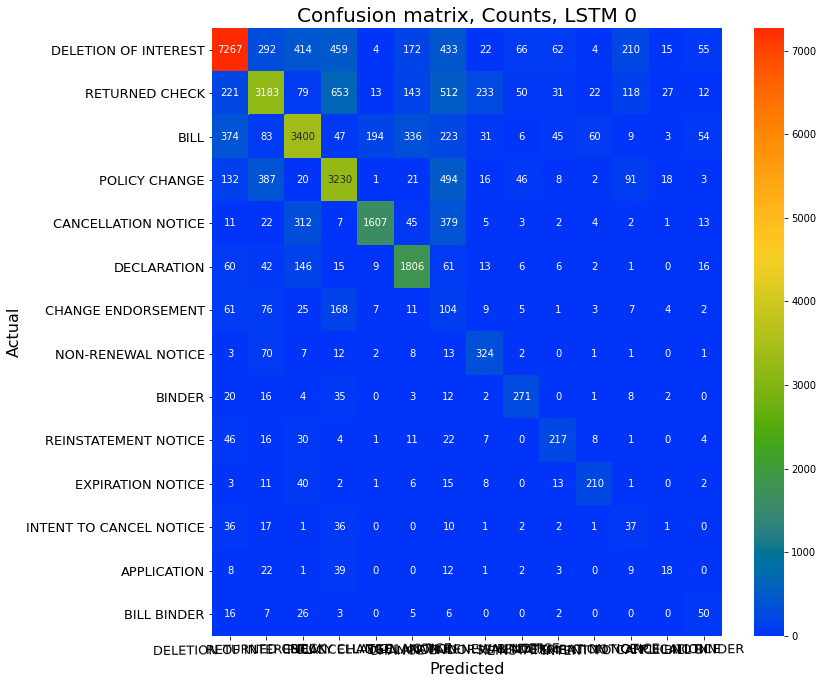

In [44]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ph.plotConfusionMatrix(confusionMat, saveAs=None, xlabels=categories,
                       ylabels=categories, titleText = 'LSTM 0',
                       ax = ax,  xlabelFontSz=labelFontSz,
                       xtickRotate=0.65, ytickRotate=0.0,
                       ylabelFontSz=labelFontSz, xtickFontSz=tickFontSz,
                       ytickFontSz=tickFontSz, titleFontSz=titleFontSz)

##### Plot recall confusion matrix

* normalized by *row*
* diagonal elements now represent the *recall* for each class

fileNameAugmentString:
 Lstm0
Δt:  0.40s.


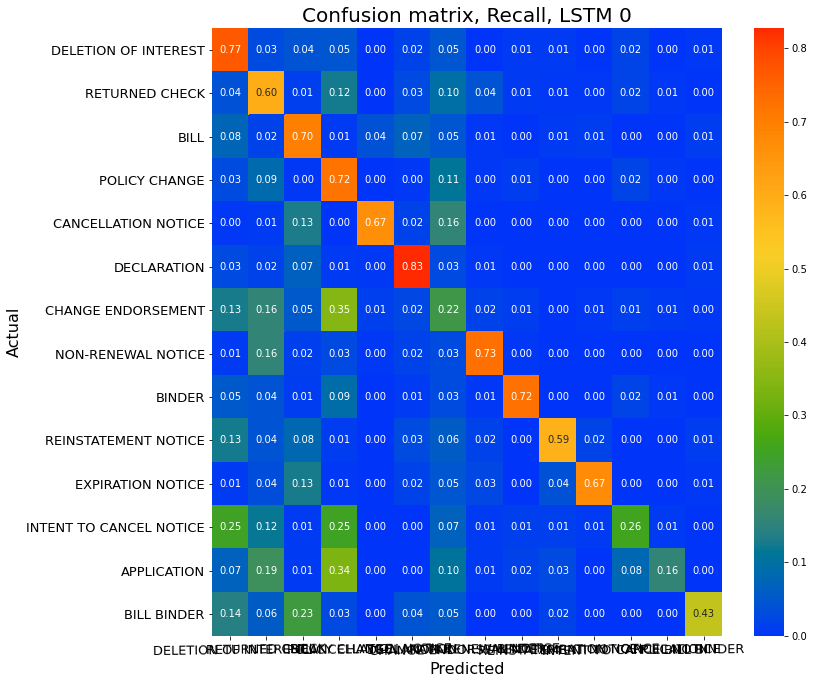

In [45]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ph.plotConfusionMatrix(confusionMat, saveAs=None, xlabels=categories,
                       ylabels=categories, titleText = 'LSTM 0',
                       ax = ax, xlabelFontSz=labelFontSz,
                       xtickRotate=0.65, ytickRotate=0.0, type='recall',
                       ylabelFontSz=labelFontSz, xtickFontSz=tickFontSz,
                       ytickFontSz=tickFontSz, titleFontSz=titleFontSz)

##### Plot precision confusion matrix

* normalized by *column*
* diagonal elements now represent the *precision* for each class

fileNameAugmentString:
 Lstm0
Δt:  0.40s.


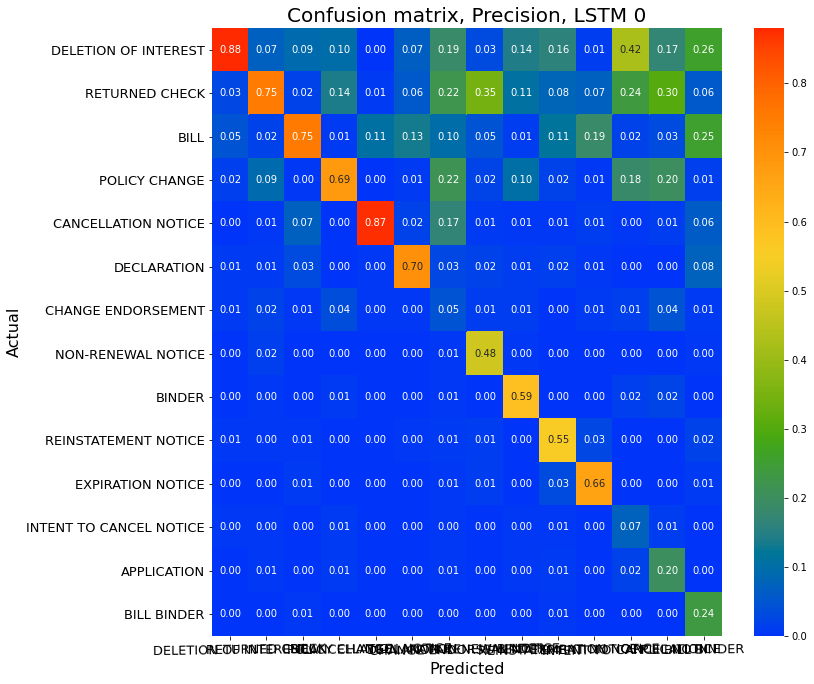

In [46]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ph.plotConfusionMatrix(confusionMat, saveAs=None, xlabels=categories,
                       ylabels=categories, titleText = 'LSTM 0',
                       ax = ax,  xlabelFontSz=labelFontSz,
                       xtickRotate=0.65, ytickRotate=0.0, type='precision',
                       ylabelFontSz=labelFontSz, xtickFontSz=tickFontSz,
                       ytickFontSz=tickFontSz, titleFontSz=titleFontSz)

<a id="lstm1-parameters"></a>
### LSTM 1

#### baseline model parameters

* Bidirectional(LSTM) only
* `LSTMlayerUnits = 128`		🢢
* `maxDocWords = 64`

Refer to the [LSTM 0 & LSTM 1 tokenize](#tokenize-64-tokens) section for the size of `maxVocabCt`.

|parameter|&nbsp;&nbsp;|description|
|:--------|------------|:----------|
|`testFrac`||fraction of data set withheld|
|`LSTMlayerUnits`||# units within each activation unit in LSTMs|
|`embeddingDim'||size of dimension for generated embeddings|
|`auxFeaturesCt`||# of features in auxiliary data|
|`classCt`||# classes (softmax output dim)|
|`dropoutFrac`||dropout fraction|
|`LSTMdropoutFrac`||dropout fraction within LSTMs|
|`batchSz`||size of batches|
|`epochCt`||number of epochs to run|

In [47]:
testFrac = 0.5
LSTMlayerUnits = 128		# 🢢🢢🢢
embeddingDim = 64
classCt = len(categoriesBySupport)
dropoutFrac = 0.15
LSTMdropoutFrac = 0.5
# LSTMdropoutFrac = 0			# Must be 0 for use of cudnn
batchSz = 64
epochCt = 30

#### Save space

In [98]:
del LSTM0

#### LSTM 1 callbacks

* checkpoints
* TensorBoard
* (no early stopping)

In [48]:
modelInstanceDir = (f"vocabCt{maxVocabCt:06d}maxCommentLen{maxDocWords:03d}"
                    + f"classCt{classCt:02d}"
                    + f"embedDim{embeddingDim:03d}"
                    + f"LSTMlayerSz{LSTMlayerUnits:03d}batchSz{batchSz:03d}"
                    + f"dropoutFrac{dropoutFrac:4.2f}"
                    + f"LSTMdropoutFrac{dropoutFrac:4.2f}")
print(modelInstanceDir, "\n")

checkpointPrefix = os.path.join(checkpointPath, modelInstanceDir,
                                "ckpt{epoch:03d}")
print(checkpointPrefix, "\n")

checkpointCallback=ModelCheckpoint(filepath=checkpointPrefix,
                                   save_weights_only=True)
os.makedirs(tensorBoardPath, exist_ok=True)                       

logsDir = os.path.join(tensorBoardPath, modelInstanceDir)
print(logsDir, "\n")

os.makedirs(logsDir, exist_ok=True)
tensorboardCallback = TensorBoard(log_dir=logsDir, histogram_freq=1)

vocabCt100000maxCommentLen064classCt14embedDim064LSTMlayerSz128batchSz064dropoutFrac0.15LSTMdropoutFrac0.15 

/home/mark/work/document-classification-test/checkpoints/vocabCt100000maxCommentLen064classCt14embedDim064LSTMlayerSz128batchSz064dropoutFrac0.15LSTMdropoutFrac0.15/ckpt{epoch:03d} 

/home/mark/work/document-classification-test/tensorBoardLogs/vocabCt100000maxCommentLen064classCt14embedDim064LSTMlayerSz128batchSz064dropoutFrac0.15LSTMdropoutFrac0.15 



#### Load or instantiate LSTM 1

In [49]:
LSTM1name = 'LSTM1'

if (modelPath / LSTM1name).is_file():
    print(f"Loading {LSTM1name} model from disk.")
    LSTM1 = load(modelPath / LSTM1name)
else:
    np.random.seed(0)  # Set a random seed for reproducibility

    print("Instantiate LSTM 1, using model0 ...")
    with device('/device:GPU:1'):
        LSTM1 = model0(maxDocWords, maxVocabCt, classCt, LSTMlayerUnits,
                       embeddingDim, softMaxCt=classCt)
    LSTM1.summary()

Instantiate LSTM 1, using model0 ...
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
MainInput (InputLayer)       [(None, 64)]              0         
_________________________________________________________________
EmbedLayer (Embedding)       (None, 64, 64)            6400000   
_________________________________________________________________
BidrectionalLSTM (Bidirectio (None, 256)               197632    
_________________________________________________________________
Dense0 (Dense)               (None, 64)                16448     
_________________________________________________________________
Dense1 (Dense)               (None, 64)                4160      
_________________________________________________________________
MainOutput (Dense)           (None, 14)                910       
Total params: 6,619,150
Trainable params: 6,619,150
Non-trainable params: 0
____________

#### Compile LSTM 1

In [50]:
if not (modelPath / LSTM1name).is_file():
    with device('/device:GPU:1'):
      LSTM1.compile(optimizer='rmsprop',
                  loss='sparse_categorical_crossentropy',
                  # metrics = ['accuracy', Recall(), Precision(),
                  #            F1Score(num_classes=classCt), 'categorical_crossentropy'])
                  metrics = ['accuracy', SparseCategoricalCrossentropy(from_logits=False)])

<a id="train-lstm1"></a>
#### Train LSTM 1

In [51]:
if not (modelPath / LSTM1name).is_file():
    print(epochCt, batchSz)
    print(classWeights)
    with device('/device:GPU:1'):
        history1 = LSTM1.fit(x=XdocsTr,
                             y= yTr.values,
                             epochs=epochCt, batch_size=batchSz,
                             shuffle=True,
                             class_weight=classWeights,
                             validation_split=0.2,
                             callbacks=[checkpointCallback, tensorboardCallback],
                             verbose=1)

30 64
{0: 0.2341198643045609, 1: 0.41878152053723133, 2: 0.456062030075188, 3: 0.4963718313460985, 4: 0.9193061393641584, 5: 1.0156985871271587, 6: 4.592724046140195, 7: 4.984911717495987, 8: 5.9154285714285715, 9: 6.044375243285325, 10: 7.1098901098901095, 11: 15.404761904761905, 12: 19.458646616541355, 13: 19.458646616541355}
Epoch 1/30
389/389 [==============================] - 126s 316ms/step - loss: 2.4308 - accuracy: 0.2910 - sparse_categorical_crossentropy: 2.3250 - val_loss: 1.7070 - val_accuracy: 0.4280 - val_sparse_categorical_crossentropy: 1.7070
Epoch 2/30
389/389 [==============================] - 118s 304ms/step - loss: 1.5735 - accuracy: 0.4775 - sparse_categorical_crossentropy: 1.4914 - val_loss: 1.4491 - val_accuracy: 0.5448 - val_sparse_categorical_crossentropy: 1.4491
Epoch 3/30
389/389 [==============================] - 118s 303ms/step - loss: 1.1958 - accuracy: 0.6132 - sparse_categorical_crossentropy: 1.1994 - val_loss: 1.0646 - val_accuracy: 0.6677 - val_sparse_c

#### Save LSTM 1, if new model

In [52]:
if not (modelPath / LSTM1name).is_file():
    print(f"Saving {LSTM1name} to disk.")
    LSTM1.save(modelPath / LSTM1name)

Saving LSTM1 to disk.
INFO:tensorflow:Assets written to: /home/mark/work/document-classification-test/model/LSTM1/assets


#### LSTM 1 inference on test data

In [53]:
softmaxOut = LSTM1.predict(x=XdocsTe)
yPred = np.argmax(softmaxOut, axis=1)

In [55]:
confusionMat = confusion_matrix(yTe, yPred)
print(confusionMat)

[[6603  522  312  285   32   59  314   30   20  129   19  730   97  323]
 [ 185 3358   61  426   31   43  352  385   32   28   18  244   91   43]
 [ 431  109 2944   68  453  172  316   28    5   42   97   28   17  155]
 [ 120  562   27 2963    7   11  338   40   27   12    4  219  114   25]
 [  11   23  130   15 2001   17  151    8    1    8   21    6    3   18]
 [  30   54  169    9   11 1715   84   25    8   10   28    7    6   27]
 [  41   98   21  152   10    7   75    9    3    6    5   26   22    8]
 [   6   79    4    7    9    3   10  317    1    0    1    6    0    1]
 [  26   35    6   21    0   10   15    4  241    1    0   10    3    2]
 [  45   23    8    5    5    8   15    5    0  202   22   15    2   12]
 [   1    4   25    1    9    3   16    6    0    9  219    2    4   13]
 [  24   17    3   27    0    0    7    2    2    3    1   49    6    3]
 [   3   17    1   14    0    1   13    2    3    0    0   20   40    1]
 [  17    8   10    3    2    2   10    1    1    2

In [56]:
np.where(np.sum(confusionMat, axis=0) == 0)

(array([], dtype=int64),)

In [57]:
accuracy = np.trace(confusionMat)/np.sum(confusionMat)
recall = np.diag(confusionMat)/np.sum(confusionMat, axis=1)
precision = np.diag(confusionMat)/np.sum(confusionMat, axis=0)
print(f"accuracy: {accuracy:0.3f}, "
      f"<precision>: {np.mean(precision):0.3f}, "
      f"<recall>: {np.mean(recall):0.3f}")

accuracy: 0.669, <precision>: 0.499, <recall>: 0.582


##### Classification report

In [58]:
classificationReport = classification_report(yTe.values, yPred,
                                             target_names=[str(c)for c in categoriesBySupport])
print(classificationReport)

                         precision    recall  f1-score   support

                   BILL       0.88      0.70      0.78      9475
          POLICY CHANGE       0.68      0.63      0.66      5297
    CANCELLATION NOTICE       0.79      0.61      0.69      4865
                 BINDER       0.74      0.66      0.70      4469
   DELETION OF INTEREST       0.78      0.83      0.80      2413
   REINSTATEMENT NOTICE       0.84      0.79      0.81      2183
            DECLARATION       0.04      0.16      0.07       483
     CHANGE ENDORSEMENT       0.37      0.71      0.49       444
         RETURNED CHECK       0.70      0.64      0.67       374
      EXPIRATION NOTICE       0.45      0.55      0.49       367
     NON-RENEWAL NOTICE       0.50      0.70      0.58       312
            BILL BINDER       0.04      0.34      0.07       144
            APPLICATION       0.10      0.35      0.15       115
INTENT TO CANCEL NOTICE       0.08      0.48      0.14       115

               accuracy

##### Sorted `classificationReport`

* Order by support

In [59]:
print(ph.sortClassificationReport(classificationReport))

                         precision    recall  f1-score   support

                   BILL       0.88      0.70      0.78      9475
          POLICY CHANGE       0.68      0.63      0.66      5297
    CANCELLATION NOTICE       0.79      0.61      0.69      4865
                 BINDER       0.74      0.66      0.70      4469
   DELETION OF INTEREST       0.78      0.83      0.80      2413
   REINSTATEMENT NOTICE       0.84      0.79      0.81      2183
            DECLARATION       0.04      0.16      0.07       483
     CHANGE ENDORSEMENT       0.37      0.71      0.49       444
         RETURNED CHECK       0.70      0.64      0.67       374
      EXPIRATION NOTICE       0.45      0.55      0.49       367
     NON-RENEWAL NOTICE       0.50      0.70      0.58       312
            BILL BINDER       0.04      0.34      0.07       144
            APPLICATION       0.10      0.35      0.15       115
INTENT TO CANCEL NOTICE       0.08      0.48      0.14       115

               accuracy

##### Plot confusion matrix

* As this is a straight confusion matrix, diagonal elements mostly reflect class size in test set
* *This is hard to interpret by visual inspection alone*

In [60]:
labelFontSz = 16
tickFontSz = 13
titleFontSz = 20

fileNameAugmentString:
 Lstm1
Δt:  0.39s.


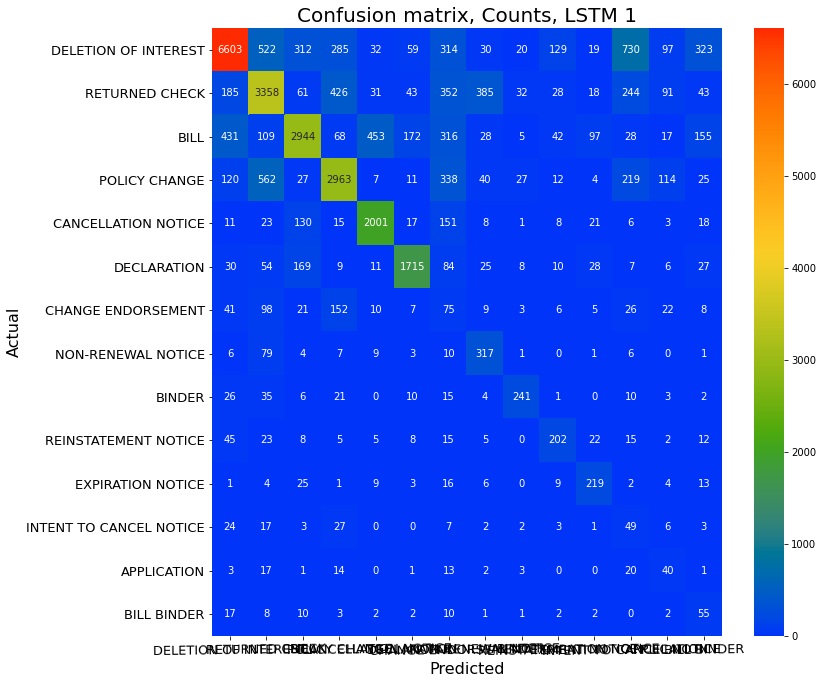

In [61]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ph.plotConfusionMatrix(confusionMat, saveAs=None, xlabels=categories,
                       ylabels=categories, titleText = 'LSTM 1',
                       ax = ax,  xlabelFontSz=labelFontSz,
                       xtickRotate=0.65, ytickRotate=0.0,
                       ylabelFontSz=labelFontSz, xtickFontSz=tickFontSz,
                       ytickFontSz=tickFontSz, titleFontSz=titleFontSz)

##### Plot recall confusion matrix

* normalized by *row*
* diagonal elements now represent the *recall* for each class

fileNameAugmentString:
 Lstm1
Δt:  0.41s.


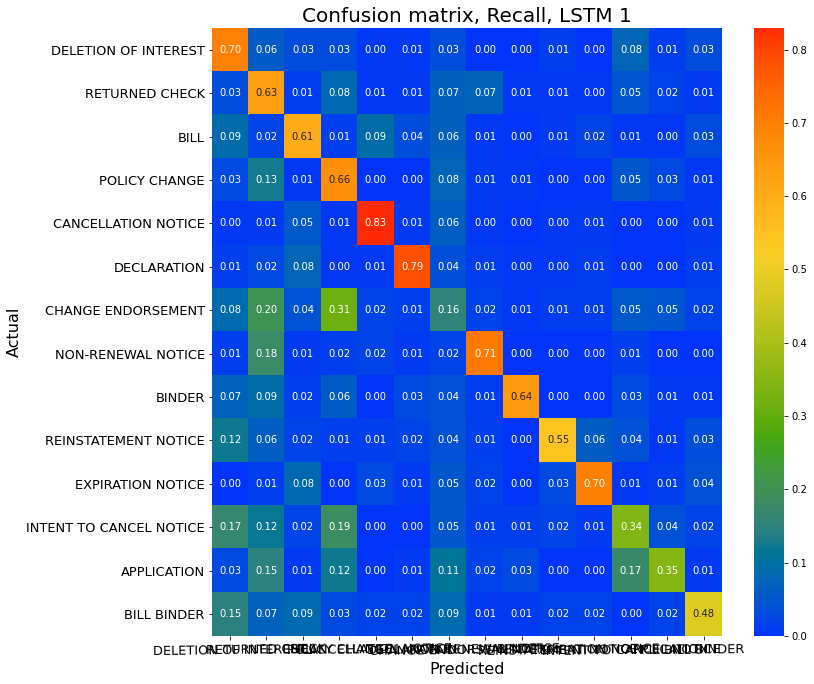

In [62]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ph.plotConfusionMatrix(confusionMat, saveAs=None, xlabels=categories,
                       ylabels=categories, titleText = 'LSTM 1',
                       ax = ax, xlabelFontSz=labelFontSz,
                       xtickRotate=0.65, ytickRotate=0.0, type='recall',
                       ylabelFontSz=labelFontSz, xtickFontSz=tickFontSz,
                       ytickFontSz=tickFontSz, titleFontSz=titleFontSz)

##### Plot precision confusion matrix

* normalized by *column*
* diagonal elements now represent the *precision* for each class

fileNameAugmentString:
 Lstm1
Δt:  0.41s.


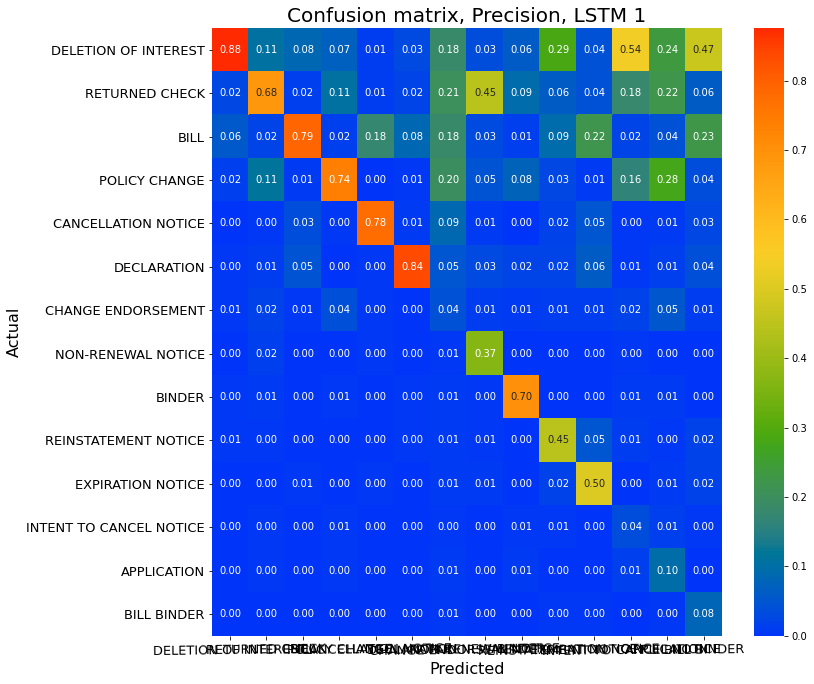

In [63]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ph.plotConfusionMatrix(confusionMat, saveAs=None, xlabels=categories,
                       ylabels=categories, titleText = 'LSTM 1',
                       ax = ax,  xlabelFontSz=labelFontSz,
                       xtickRotate=0.65, ytickRotate=0.0, type='precision',
                       ylabelFontSz=labelFontSz, xtickFontSz=tickFontSz,
                       ytickFontSz=tickFontSz, titleFontSz=titleFontSz)

<a id="tokenize-128-tokens"></a>
### LSTM 2 tokenize

* truncate docs to `maxDocWords = 128` tokens
* pre-pad shorter docs with 0s

##### Tensor of word indices for train

In [66]:
padValue = 0
maxDocWords = 128		# 🢢🢢🢢

XdocsTr = pad_sequences(listOfListsOfWordIndicesTr,
                        maxlen=maxDocWords,
                        dtype='int32', padding='pre',
                        truncating='post', value=padValue)

In [67]:
ListOfDocsTr[0]
print(listOfListsOfWordIndicesTr[0])
XdocsTr[0]

'776d8e8eda28 9d9120c02975 ce015f48ae93 52152b0093a1 5cf416836ddd 21d06acb5c5a 82c32a96c28a fc25f79e6d18 4ef731a80c24 758684f862e4 688c4bbfca80 9e2b31af60e1 c29f0593f229 9c58ed44374f 635ad16e1001 6e2c9c88b447 6ce6cc5a3203 c85b3821556b 89aed7fbfb0e 2e85d01c5d75 e7f10ad56136 2053a6a9efee fb1a3ce496b1 26f768da5068 0a8965c4b8f4 6af770640118 11610fcf8c49 f2b0e028fe2c 72bd4a50cf4a 54709b24b45f 823c39d495d0 6af770640118 6b304aabdcee 335e39009eab cf8a124d4e59 cb7631b88e51 304a68728141 97b6014f9e50 26f768da5068 6af770640118 e137a75c0b90 d5f4611022c1 46c88d9303da d63be9e66da8 4d134e3d5af5 f95d0bea231b 6ce6cc5a3203 6365c4563bd1 6df520735456 6365c4563bd1 6e34c0d3d1aa 6365c4563bd1 46c88d9303da 6365c4563bd1 6365c4563bd1 ff8452befa25 3593bd452331 81dc2e5c1272 d78dc767a475 3689f1b1fc46 ccef80e38b2b f6f466726339 39d83a0aee75 ab399ebcc0fe b9925442c9c9 07b4174549d4 395a5e8185f8 bc5e0615b2da 32f49d072772 53d94d11f6bb 8565203321d4 93977e7acdcf 93790ade6682 eb51798a89e1 9bc65adc033c 97b6014f9e50 26f768da506

[673, 8480, 1911, 1, 29094, 1, 33264, 157, 1395, 399, 6626, 33265, 1, 20636, 4438, 5594, 4, 214, 1327, 73, 204, 17094, 4687, 36, 1, 32, 1, 224, 182, 12, 42966, 32, 21, 10648, 1, 256, 1, 23, 36, 32, 407, 184, 52, 299, 33266, 17, 4, 49, 226, 49, 22415, 49, 52, 49, 49, 943, 1411, 29095, 648, 350, 1, 369, 79132, 726, 723, 568, 265, 4916, 1308, 1, 47871, 1, 44, 63, 33, 23, 36, 32, 36, 7511, 1, 19, 530, 753, 2829, 878, 5595, 21, 35843, 3240, 1170, 73, 153, 9140, 54, 935, 11657, 8722, 1, 2550, 299, 673, 1333, 1, 655, 17095, 5972, 407, 42, 130, 867, 1695, 53, 250, 380, 7, 175, 867, 27, 146, 42, 22416, 1, 3284, 21, 12, 5230, 27, 1, 8481, 1, 31, 177, 655, 42967, 1, 51, 218, 15, 1385, 402, 381, 1, 101, 42, 1, 407, 655, 73, 1, 21, 52, 1029, 17, 6, 326, 122, 577, 5654, 19, 232, 15, 183, 110, 233, 15, 90, 44, 188, 41, 1, 47, 100, 8, 33, 57, 38, 49, 5509, 225, 33, 136, 78, 19, 232, 15, 77, 142, 4500, 39, 655, 82, 34, 25942, 12698, 418, 5509, 225, 12229, 51, 218, 14, 901, 74, 54732, 2, 1199, 67, 12698

array([  673,  8480,  1911,     1, 29094,     1, 33264,   157,  1395,
         399,  6626, 33265,     1, 20636,  4438,  5594,     4,   214,
        1327,    73,   204, 17094,  4687,    36,     1,    32,     1,
         224,   182,    12, 42966,    32,    21, 10648,     1,   256,
           1,    23,    36,    32,   407,   184,    52,   299, 33266,
          17,     4,    49,   226,    49, 22415,    49,    52,    49,
          49,   943,  1411, 29095,   648,   350,     1,   369, 79132,
         726,   723,   568,   265,  4916,  1308,     1, 47871,     1,
          44,    63,    33,    23,    36,    32,    36,  7511,     1,
          19,   530,   753,  2829,   878,  5595,    21, 35843,  3240,
        1170,    73,   153,  9140,    54,   935, 11657,  8722,     1,
        2550,   299,   673,  1333,     1,   655, 17095,  5972,   407,
          42,   130,   867,  1695,    53,   250,   380,     7,   175,
         867,    27,   146,    42, 22416,     1,  3284,    21,    12,
        5230,    27]

##### Tensor of word indices for test

In [68]:
ListOfDocsTe = list(dfTe.docText)
listOfListsOfWordIndicesTe = tokenizer.texts_to_sequences(ListOfDocsTe)
XdocsTe = pad_sequences(listOfListsOfWordIndicesTe,
                        maxlen=maxDocWords,
                        dtype='int32', padding='pre',
                        truncating='post', value=padValue)

In [69]:
ListOfDocsTe[0]
print(listOfListsOfWordIndicesTe[0])
XdocsTe[0]

'a0c020166d79 133d46f7ed38 fe64d3cdfe5b 36e7aa72ffe1 7a5e719bafba fafeb212675a ff1c26ea0b6f 93c988b67c47 0562c756a2f2 07e7fe209a3b ff714b9fa7fd fe64d3cdfe5b c9a53ea6e219 993ff2804aa9 cbd6e2e7a804 e4c167e314c2 1851758c92b2 e259a56993f4 e94953618947 c79b01c5629d 6ce6cc5a3203 094e2de7e1cd 4ba791167817 9bfc4c4973a6 82204d3e715e 5dc7c49eb85d 2ed97f462806 a51c4e06df28 db3176de6e95 21e314d3afcc 2ee5e18ba524 586242498a88 360e8b28421c df7b799d2534 4a68a8674193 0f88ca127938 9a1d3ab82b96 1e5c095af1d7 71144e880c8d 7d9e333a86da ab876af5ae0b faaa1c06b512 21e314d3afcc e6dbab0cbfb4 5892ad716bb7 d493c688fb66 4ffb12504ac6 e9b0e655984e 347a5d991fe1 0a9b859f7b89 9e851f85cce7 4895c4bdb608 1015893e384a 8f7a92cd0ae7 21e314d3afcc 40fbee1e4d5c 1068682ce752 415fc0f6a895 586242498a88 ac6bf0e47705 21e314d3afcc 09b305bd6c36 664aa24ff74f 427028e08976 11269ab19093 21e314d3afcc becb9d433d2c 327f094890d6 1669ab06727a a263b63bc282 97b6014f9e50 b01c6237ae4a a9ee836e8303 e259a56993f4 ba8f19d976a8 133d46f7ed38 0c4ce226d9f

[71, 9, 118, 53, 209, 8795, 269, 171, 19, 808, 249, 118, 83, 1, 178, 2313, 1188, 135, 232, 218, 4, 1261, 301, 291, 1240, 3305, 372, 1, 1307, 6, 30555, 2, 97, 1037, 647, 286, 707, 4109, 465, 20, 1, 13429, 6, 1233, 366, 125, 128, 7828, 490, 1268, 2177, 7720, 8, 132, 6, 872, 29, 1574, 2, 825, 6, 549, 559, 231, 261, 6, 6289, 579, 244, 574, 23, 1104, 163, 135, 101, 9, 78, 8795, 174, 31526, 1093, 357, 30, 135, 9, 109, 184, 370, 465, 17995, 8790, 787, 6, 218, 1788, 1, 1759, 1991, 266, 787, 2179, 228, 2278, 30, 2201, 494, 2338, 86, 662, 816, 72, 922, 1037, 286, 291, 3305, 4, 3, 165, 1, 353, 23, 367, 8795, 9, 3690, 19, 283, 73, 266, 3, 3283, 122, 165, 209, 269, 2313, 1, 1, 119, 28820, 171, 180, 3, 4165, 80, 9855, 1261, 19, 688, 6, 218, 2, 412, 132, 8795, 16, 19, 78, 132, 871, 78, 132, 14, 1718, 6850, 18129, 208, 37, 943, 1, 4736, 195, 120, 464, 53, 8795, 197, 229, 90, 233, 6, 835, 835, 340, 56, 370, 2, 257, 8, 8795, 2, 149, 13929, 505, 27, 84, 19, 158, 15, 190, 457, 1431, 2378, 409, 743, 3321, 

array([   71,     9,   118,    53,   209,  8795,   269,   171,    19,
         808,   249,   118,    83,     1,   178,  2313,  1188,   135,
         232,   218,     4,  1261,   301,   291,  1240,  3305,   372,
           1,  1307,     6, 30555,     2,    97,  1037,   647,   286,
         707,  4109,   465,    20,     1, 13429,     6,  1233,   366,
         125,   128,  7828,   490,  1268,  2177,  7720,     8,   132,
           6,   872,    29,  1574,     2,   825,     6,   549,   559,
         231,   261,     6,  6289,   579,   244,   574,    23,  1104,
         163,   135,   101,     9,    78,  8795,   174, 31526,  1093,
         357,    30,   135,     9,   109,   184,   370,   465, 17995,
        8790,   787,     6,   218,  1788,     1,  1759,  1991,   266,
         787,  2179,   228,  2278,    30,  2201,   494,  2338,    86,
         662,   816,    72,   922,  1037,   286,   291,  3305,     4,
           3,   165,     1,   353,    23,   367,  8795,     9,  3690,
          19,   283]

<a id="lstm2-parameters"></a>
### LSTM 2

#### baseline model parameters

* Bidirectional(LSTM) only
* `LSTMlayerUnits = 128`
* `maxDocWords = 128`		🢢

Refer to the [LSTM 2](#tokenize-128-tokens) section for the size of `maxVocabCt`.

|parameter|&nbsp;&nbsp;|description|
|:--------|------------|:----------|
|`testFrac`||fraction of data set withheld|
|`LSTMlayerUnits`||# units within each activation unit in LSTMs|
|`embeddingDim'||size of dimension for generated embeddings|
|`auxFeaturesCt`||# of features in auxiliary data|
|`classCt`||# classes (softmax output dim)|
|`dropoutFrac`||dropout fraction|
|`LSTMdropoutFrac`||dropout fraction within LSTMs|
|`batchSz`||size of batches|
|`epochCt`||number of epochs to run|

In [70]:
testFrac = 0.5
LSTMlayerUnits = 128
embeddingDim = 64
classCt = len(categoriesBySupport)
dropoutFrac = 0.15
LSTMdropoutFrac = 0.5
# LSTMdropoutFrac = 0			# Must be 0 for use of cudnn
batchSz = 64
epochCt = 30

#### Save space

In [99]:
del LSTM1

#### LSTM 2 callbacks

* checkpoints
* TensorBoard
* (no early stopping)

In [71]:
modelInstanceDir = (f"vocabCt{maxVocabCt:06d}maxCommentLen{maxDocWords:03d}"
                    + f"classCt{classCt:02d}"
                    + f"embedDim{embeddingDim:03d}"
                    + f"LSTMlayerSz{LSTMlayerUnits:03d}batchSz{batchSz:03d}"
                    + f"dropoutFrac{dropoutFrac:4.2f}"
                    + f"LSTMdropoutFrac{dropoutFrac:4.2f}")
print(modelInstanceDir, "\n")

checkpointPrefix = os.path.join(checkpointPath, modelInstanceDir,
                                "ckpt{epoch:03d}")
print(checkpointPrefix, "\n")

checkpointCallback=ModelCheckpoint(filepath=checkpointPrefix,
                                   save_weights_only=True)
os.makedirs(tensorBoardPath, exist_ok=True)                       

logsDir = os.path.join(tensorBoardPath, modelInstanceDir)
print(logsDir, "\n")

os.makedirs(logsDir, exist_ok=True)
tensorboardCallback = TensorBoard(log_dir=logsDir, histogram_freq=1)

vocabCt100000maxCommentLen128classCt14embedDim064LSTMlayerSz128batchSz064dropoutFrac0.15LSTMdropoutFrac0.15 

/home/mark/work/document-classification-test/checkpoints/vocabCt100000maxCommentLen128classCt14embedDim064LSTMlayerSz128batchSz064dropoutFrac0.15LSTMdropoutFrac0.15/ckpt{epoch:03d} 

/home/mark/work/document-classification-test/tensorBoardLogs/vocabCt100000maxCommentLen128classCt14embedDim064LSTMlayerSz128batchSz064dropoutFrac0.15LSTMdropoutFrac0.15 



#### Load or instantiate LSTM 2

In [72]:
LSTM2name = 'LSTM2'

if (modelPath / LSTM2name).is_file():
    print(f"Loading {LSTM2name} model from disk.")
    LSTM2 = load(modelPath / LSTM2name)
else:
    np.random.seed(0)  # Set a random seed for reproducibility

    print("Instantiate LSTM 2, using model0 ...")
    with device('/device:GPU:1'):
        LSTM2 = model0(maxDocWords, maxVocabCt, classCt, LSTMlayerUnits,
                       embeddingDim, softMaxCt=classCt)
    LSTM2.summary()

Instantiate LSTM 2, using model0 ...
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
MainInput (InputLayer)       [(None, 128)]             0         
_________________________________________________________________
EmbedLayer (Embedding)       (None, 128, 64)           6400000   
_________________________________________________________________
BidrectionalLSTM (Bidirectio (None, 256)               197632    
_________________________________________________________________
Dense0 (Dense)               (None, 64)                16448     
_________________________________________________________________
Dense1 (Dense)               (None, 64)                4160      
_________________________________________________________________
MainOutput (Dense)           (None, 14)                910       
Total params: 6,619,150
Trainable params: 6,619,150
Non-trainable params: 0
____________

#### Compile LSTM 2

In [73]:
if not (modelPath / LSTM2name).is_file():
    with device('/device:GPU:1'):
      LSTM2.compile(optimizer='rmsprop',
                  loss='sparse_categorical_crossentropy',
                  # metrics = ['accuracy', Recall(), Precision(),
                  #            F1Score(num_classes=classCt), 'categorical_crossentropy'])
                  metrics = ['accuracy'])

<a id="train-lstm2"></a>
#### Train LSTM 2

In [74]:
if not (modelPath / LSTM2name).is_file():
    print(epochCt, batchSz)
    print(classWeights)
    with device('/device:GPU:1'):
        history2 = LSTM2.fit(x=XdocsTr,
                             y= yTr.values,
                             epochs=epochCt, batch_size=batchSz,
                             shuffle=True,
                             class_weight=classWeights,
                             validation_split=0.2,
                             callbacks=[checkpointCallback, tensorboardCallback],
                             verbose=1)

30 64
{0: 0.2341198643045609, 1: 0.41878152053723133, 2: 0.456062030075188, 3: 0.4963718313460985, 4: 0.9193061393641584, 5: 1.0156985871271587, 6: 4.592724046140195, 7: 4.984911717495987, 8: 5.9154285714285715, 9: 6.044375243285325, 10: 7.1098901098901095, 11: 15.404761904761905, 12: 19.458646616541355, 13: 19.458646616541355}
Epoch 1/30
389/389 [==============================] - 251s 634ms/step - loss: 2.3942 - accuracy: 0.1761 - val_loss: 1.9361 - val_accuracy: 0.3026
Epoch 2/30
389/389 [==============================] - 240s 616ms/step - loss: 1.7529 - accuracy: 0.3703 - val_loss: 1.5448 - val_accuracy: 0.5580
Epoch 3/30
389/389 [==============================] - 239s 615ms/step - loss: 1.3579 - accuracy: 0.6222 - val_loss: 1.0964 - val_accuracy: 0.6864
Epoch 4/30
389/389 [==============================] - 240s 616ms/step - loss: 1.1073 - accuracy: 0.6757 - val_loss: 1.6350 - val_accuracy: 0.5563
Epoch 5/30
389/389 [==============================] - 240s 617ms/step - loss: 0.8559 -

#### Save LSTM 2, if new model

In [75]:
if not (modelPath / LSTM2name).is_file():
    print(f"Saving {LSTM2name} to disk.")
    LSTM2.save(modelPath / LSTM2name)

Saving LSTM2 to disk.
INFO:tensorflow:Assets written to: /home/mark/work/document-classification-test/model/LSTM2/assets


#### LSTM 2 inference on test data

In [76]:
softmaxOut = LSTM2.predict(x=XdocsTe)
yPred = np.argmax(softmaxOut, axis=1)

In [78]:
confusionMat = confusion_matrix(yTe, yPred)
print(confusionMat)

[[7394  404  378  239    4   68  243    3   34  246   31  280  114   37]
 [ 356 3222   48  408   33   47  511  107    5   95   60  200  189   16]
 [ 436   74 3278   52  385  141  172   19   10   66  127   11    8   86]
 [ 250  341   10 2725    7    7  568   12   25   45   15  130  330    4]
 [   3   10  141   11 1913    8  285    5    0    5   13    0    1   18]
 [  46   57   76   16    7 1830   25    2    2   49   45    3    1   24]
 [  67   82   19  102    9    6  109   10    3    9    8   22   32    5]
 [   6   38    2   10   15    2   20  332    2    4    4    5    3    1]
 [  21   15    4   21    3    4   30    1  263    1    1    5    5    0]
 [  49   14   10    2    1    3    4    0    0  241   35    4    1    3]
 [   6    6   24    3    5    4    6    0    0   24  232    1    0    1]
 [  44   24    1   17    0    2    3    0    2    5    0   31   15    0]
 [  16   10    0   19    0    0    5    0    1    5    1   13   45    0]
 [  14    1   29    3    3    6    5    0    0    9

In [79]:
np.where(np.sum(confusionMat, axis=0) == 0)

(array([], dtype=int64),)

In [80]:
accuracy = np.trace(confusionMat)/np.sum(confusionMat)
recall = np.diag(confusionMat)/np.sum(confusionMat, axis=1)
precision = np.diag(confusionMat)/np.sum(confusionMat, axis=0)
print(f"accuracy: {accuracy:0.3f}, "
      f"<precision>: {np.mean(precision):0.3f}, "
      f"<recall>: {np.mean(recall):0.3f}")

accuracy: 0.697, <precision>: 0.521, <recall>: 0.596


##### Classification report

In [81]:
classificationReport = classification_report(yTe.values, yPred,
                                             target_names=[str(c)for c in categoriesBySupport])
print(classificationReport)

                         precision    recall  f1-score   support

                   BILL       0.85      0.78      0.81      9475
          POLICY CHANGE       0.75      0.61      0.67      5297
    CANCELLATION NOTICE       0.82      0.67      0.74      4865
                 BINDER       0.75      0.61      0.67      4469
   DELETION OF INTEREST       0.80      0.79      0.80      2413
   REINSTATEMENT NOTICE       0.86      0.84      0.85      2183
            DECLARATION       0.05      0.23      0.09       483
     CHANGE ENDORSEMENT       0.68      0.75      0.71       444
         RETURNED CHECK       0.76      0.70      0.73       374
      EXPIRATION NOTICE       0.30      0.66      0.41       367
     NON-RENEWAL NOTICE       0.40      0.74      0.52       312
            BILL BINDER       0.04      0.22      0.07       144
            APPLICATION       0.06      0.39      0.10       115
INTENT TO CANCEL NOTICE       0.17      0.36      0.23       115

               accuracy

##### Sorted `classificationReport`

* Order by support

In [82]:
print(ph.sortClassificationReport(classificationReport))

                         precision    recall  f1-score   support

                   BILL       0.85      0.78      0.81      9475
          POLICY CHANGE       0.75      0.61      0.67      5297
    CANCELLATION NOTICE       0.82      0.67      0.74      4865
                 BINDER       0.75      0.61      0.67      4469
   DELETION OF INTEREST       0.80      0.79      0.80      2413
   REINSTATEMENT NOTICE       0.86      0.84      0.85      2183
            DECLARATION       0.05      0.23      0.09       483
     CHANGE ENDORSEMENT       0.68      0.75      0.71       444
         RETURNED CHECK       0.76      0.70      0.73       374
      EXPIRATION NOTICE       0.30      0.66      0.41       367
     NON-RENEWAL NOTICE       0.40      0.74      0.52       312
            BILL BINDER       0.04      0.22      0.07       144
            APPLICATION       0.06      0.39      0.10       115
INTENT TO CANCEL NOTICE       0.17      0.36      0.23       115

               accuracy

##### Plot confusion matrix

* As this is a straight confusion matrix, diagonal elements mostly reflect class size in test set
* *This is hard to interpret by visual inspection alone*

In [83]:
labelFontSz = 16
tickFontSz = 13
titleFontSz = 20

fileNameAugmentString:
 Lstm2
Δt:  0.39s.


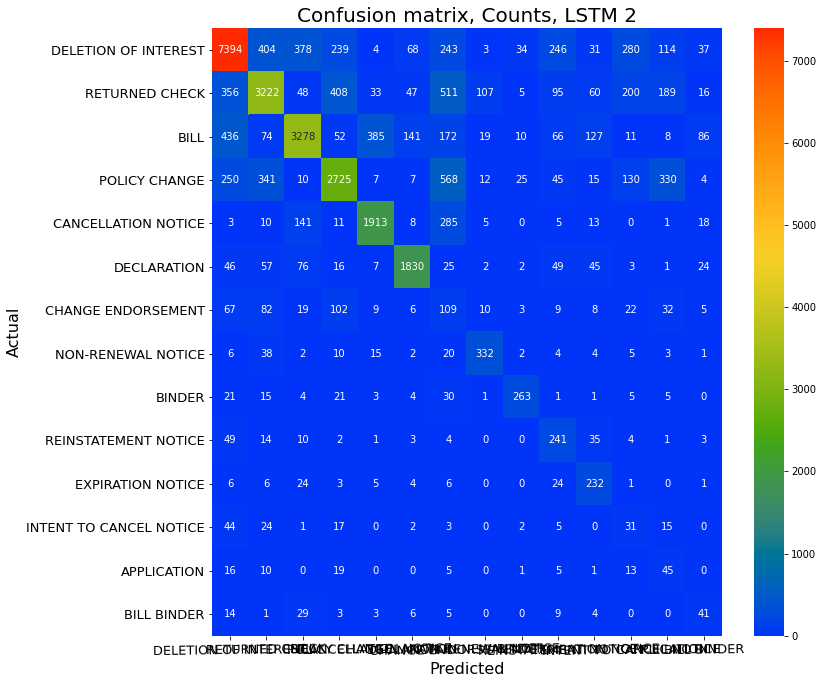

In [84]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ph.plotConfusionMatrix(confusionMat, saveAs=None, xlabels=categories,
                       ylabels=categories, titleText = 'LSTM 2',
                       ax = ax,  xlabelFontSz=labelFontSz,
                       xtickRotate=0.65, ytickRotate=0.0,
                       ylabelFontSz=labelFontSz, xtickFontSz=tickFontSz,
                       ytickFontSz=tickFontSz, titleFontSz=titleFontSz)

##### Plot recall confusion matrix

* normalized by *row*
* diagonal elements now represent the *recall* for each class

fileNameAugmentString:
 Lstm2
Δt:  0.40s.


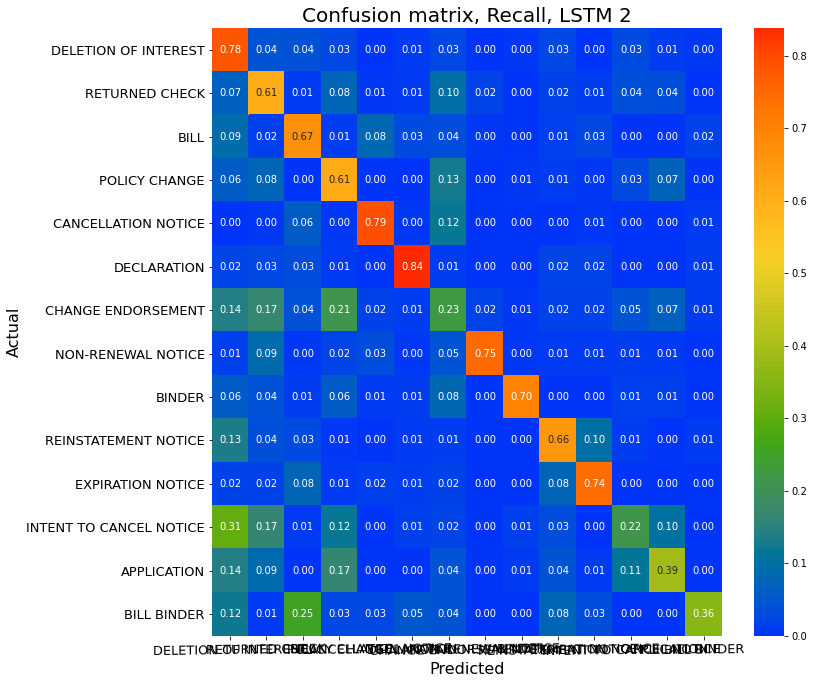

In [85]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ph.plotConfusionMatrix(confusionMat, saveAs=None, xlabels=categories,
                       ylabels=categories, titleText = 'LSTM 2',
                       ax = ax, xlabelFontSz=labelFontSz,
                       xtickRotate=0.65, ytickRotate=0.0, type='recall',
                       ylabelFontSz=labelFontSz, xtickFontSz=tickFontSz,
                       ytickFontSz=tickFontSz, titleFontSz=titleFontSz)

##### Plot precision confusion matrix

* normalized by *column*
* diagonal elements now represent the *precision* for each class

fileNameAugmentString:
 Lstm2
Δt:  0.40s.


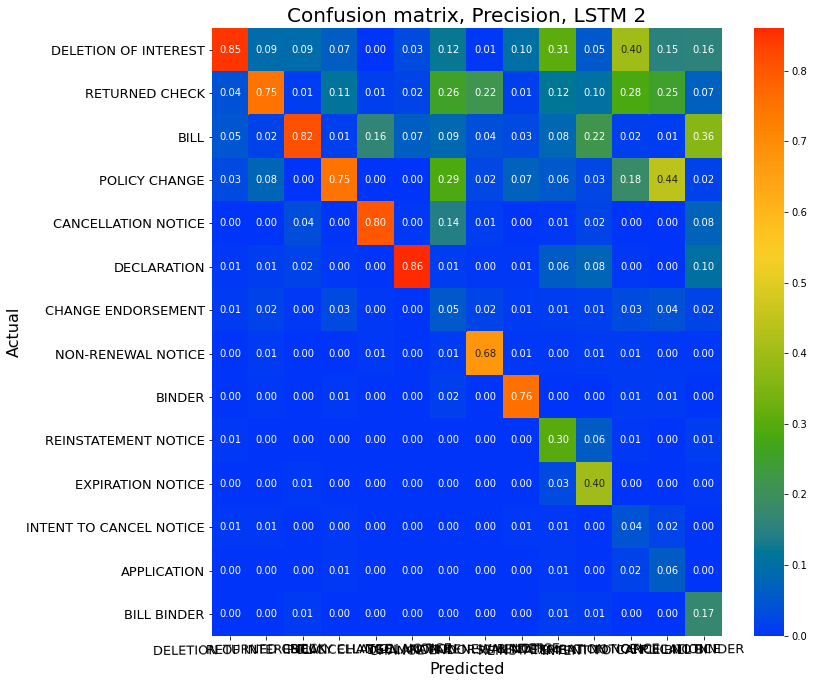

In [86]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ph.plotConfusionMatrix(confusionMat, saveAs=None, xlabels=categories,
                       ylabels=categories, titleText = 'LSTM 2',
                       ax = ax,  xlabelFontSz=labelFontSz,
                       xtickRotate=0.65, ytickRotate=0.0, type='precision',
                       ylabelFontSz=labelFontSz, xtickFontSz=tickFontSz,
                       ytickFontSz=tickFontSz, titleFontSz=titleFontSz)

<a id="tokenize-256-tokens"></a>
### LSTM 3 tokenize

* truncate docs to `maxDocWords = 256` tokens
* pre-pad shorter docs with 0s

##### Tensor of word indices for train

In [103]:
padValue = 0
maxDocWords = 256		# 🢢🢢🢢

XdocsTr = pad_sequences(listOfListsOfWordIndicesTr,
                        maxlen=maxDocWords,
                        dtype='int32', padding='pre',
                        truncating='post', value=padValue)

In [104]:
ListOfDocsTr[0]
print(listOfListsOfWordIndicesTr[0])
XdocsTr[0]

'776d8e8eda28 9d9120c02975 ce015f48ae93 52152b0093a1 5cf416836ddd 21d06acb5c5a 82c32a96c28a fc25f79e6d18 4ef731a80c24 758684f862e4 688c4bbfca80 9e2b31af60e1 c29f0593f229 9c58ed44374f 635ad16e1001 6e2c9c88b447 6ce6cc5a3203 c85b3821556b 89aed7fbfb0e 2e85d01c5d75 e7f10ad56136 2053a6a9efee fb1a3ce496b1 26f768da5068 0a8965c4b8f4 6af770640118 11610fcf8c49 f2b0e028fe2c 72bd4a50cf4a 54709b24b45f 823c39d495d0 6af770640118 6b304aabdcee 335e39009eab cf8a124d4e59 cb7631b88e51 304a68728141 97b6014f9e50 26f768da5068 6af770640118 e137a75c0b90 d5f4611022c1 46c88d9303da d63be9e66da8 4d134e3d5af5 f95d0bea231b 6ce6cc5a3203 6365c4563bd1 6df520735456 6365c4563bd1 6e34c0d3d1aa 6365c4563bd1 46c88d9303da 6365c4563bd1 6365c4563bd1 ff8452befa25 3593bd452331 81dc2e5c1272 d78dc767a475 3689f1b1fc46 ccef80e38b2b f6f466726339 39d83a0aee75 ab399ebcc0fe b9925442c9c9 07b4174549d4 395a5e8185f8 bc5e0615b2da 32f49d072772 53d94d11f6bb 8565203321d4 93977e7acdcf 93790ade6682 eb51798a89e1 9bc65adc033c 97b6014f9e50 26f768da506

[673, 8480, 1911, 1, 29094, 1, 33264, 157, 1395, 399, 6626, 33265, 1, 20636, 4438, 5594, 4, 214, 1327, 73, 204, 17094, 4687, 36, 1, 32, 1, 224, 182, 12, 42966, 32, 21, 10648, 1, 256, 1, 23, 36, 32, 407, 184, 52, 299, 33266, 17, 4, 49, 226, 49, 22415, 49, 52, 49, 49, 943, 1411, 29095, 648, 350, 1, 369, 79132, 726, 723, 568, 265, 4916, 1308, 1, 47871, 1, 44, 63, 33, 23, 36, 32, 36, 7511, 1, 19, 530, 753, 2829, 878, 5595, 21, 35843, 3240, 1170, 73, 153, 9140, 54, 935, 11657, 8722, 1, 2550, 299, 673, 1333, 1, 655, 17095, 5972, 407, 42, 130, 867, 1695, 53, 250, 380, 7, 175, 867, 27, 146, 42, 22416, 1, 3284, 21, 12, 5230, 27, 1, 8481, 1, 31, 177, 655, 42967, 1, 51, 218, 15, 1385, 402, 381, 1, 101, 42, 1, 407, 655, 73, 1, 21, 52, 1029, 17, 6, 326, 122, 577, 5654, 19, 232, 15, 183, 110, 233, 15, 90, 44, 188, 41, 1, 47, 100, 8, 33, 57, 38, 49, 5509, 225, 33, 136, 78, 19, 232, 15, 77, 142, 4500, 39, 655, 82, 34, 25942, 12698, 418, 5509, 225, 12229, 51, 218, 14, 901, 74, 54732, 2, 1199, 67, 12698

array([  673,  8480,  1911,     1, 29094,     1, 33264,   157,  1395,
         399,  6626, 33265,     1, 20636,  4438,  5594,     4,   214,
        1327,    73,   204, 17094,  4687,    36,     1,    32,     1,
         224,   182,    12, 42966,    32,    21, 10648,     1,   256,
           1,    23,    36,    32,   407,   184,    52,   299, 33266,
          17,     4,    49,   226,    49, 22415,    49,    52,    49,
          49,   943,  1411, 29095,   648,   350,     1,   369, 79132,
         726,   723,   568,   265,  4916,  1308,     1, 47871,     1,
          44,    63,    33,    23,    36,    32,    36,  7511,     1,
          19,   530,   753,  2829,   878,  5595,    21, 35843,  3240,
        1170,    73,   153,  9140,    54,   935, 11657,  8722,     1,
        2550,   299,   673,  1333,     1,   655, 17095,  5972,   407,
          42,   130,   867,  1695,    53,   250,   380,     7,   175,
         867,    27,   146,    42, 22416,     1,  3284,    21,    12,
        5230,    27,

##### Tensor of word indices for test

In [105]:
ListOfDocsTe = list(dfTe.docText)
listOfListsOfWordIndicesTe = tokenizer.texts_to_sequences(ListOfDocsTe)
XdocsTe = pad_sequences(listOfListsOfWordIndicesTe,
                        maxlen=maxDocWords,
                        dtype='int32', padding='pre',
                        truncating='post', value=padValue)

In [106]:
ListOfDocsTe[0]
print(listOfListsOfWordIndicesTe[0])
XdocsTe[0]

'a0c020166d79 133d46f7ed38 fe64d3cdfe5b 36e7aa72ffe1 7a5e719bafba fafeb212675a ff1c26ea0b6f 93c988b67c47 0562c756a2f2 07e7fe209a3b ff714b9fa7fd fe64d3cdfe5b c9a53ea6e219 993ff2804aa9 cbd6e2e7a804 e4c167e314c2 1851758c92b2 e259a56993f4 e94953618947 c79b01c5629d 6ce6cc5a3203 094e2de7e1cd 4ba791167817 9bfc4c4973a6 82204d3e715e 5dc7c49eb85d 2ed97f462806 a51c4e06df28 db3176de6e95 21e314d3afcc 2ee5e18ba524 586242498a88 360e8b28421c df7b799d2534 4a68a8674193 0f88ca127938 9a1d3ab82b96 1e5c095af1d7 71144e880c8d 7d9e333a86da ab876af5ae0b faaa1c06b512 21e314d3afcc e6dbab0cbfb4 5892ad716bb7 d493c688fb66 4ffb12504ac6 e9b0e655984e 347a5d991fe1 0a9b859f7b89 9e851f85cce7 4895c4bdb608 1015893e384a 8f7a92cd0ae7 21e314d3afcc 40fbee1e4d5c 1068682ce752 415fc0f6a895 586242498a88 ac6bf0e47705 21e314d3afcc 09b305bd6c36 664aa24ff74f 427028e08976 11269ab19093 21e314d3afcc becb9d433d2c 327f094890d6 1669ab06727a a263b63bc282 97b6014f9e50 b01c6237ae4a a9ee836e8303 e259a56993f4 ba8f19d976a8 133d46f7ed38 0c4ce226d9f

[71, 9, 118, 53, 209, 8795, 269, 171, 19, 808, 249, 118, 83, 1, 178, 2313, 1188, 135, 232, 218, 4, 1261, 301, 291, 1240, 3305, 372, 1, 1307, 6, 30555, 2, 97, 1037, 647, 286, 707, 4109, 465, 20, 1, 13429, 6, 1233, 366, 125, 128, 7828, 490, 1268, 2177, 7720, 8, 132, 6, 872, 29, 1574, 2, 825, 6, 549, 559, 231, 261, 6, 6289, 579, 244, 574, 23, 1104, 163, 135, 101, 9, 78, 8795, 174, 31526, 1093, 357, 30, 135, 9, 109, 184, 370, 465, 17995, 8790, 787, 6, 218, 1788, 1, 1759, 1991, 266, 787, 2179, 228, 2278, 30, 2201, 494, 2338, 86, 662, 816, 72, 922, 1037, 286, 291, 3305, 4, 3, 165, 1, 353, 23, 367, 8795, 9, 3690, 19, 283, 73, 266, 3, 3283, 122, 165, 209, 269, 2313, 1, 1, 119, 28820, 171, 180, 3, 4165, 80, 9855, 1261, 19, 688, 6, 218, 2, 412, 132, 8795, 16, 19, 78, 132, 871, 78, 132, 14, 1718, 6850, 18129, 208, 37, 943, 1, 4736, 195, 120, 464, 53, 8795, 197, 229, 90, 233, 6, 835, 835, 340, 56, 370, 2, 257, 8, 8795, 2, 149, 13929, 505, 27, 84, 19, 158, 15, 190, 457, 1431, 2378, 409, 743, 3321, 

array([   71,     9,   118,    53,   209,  8795,   269,   171,    19,
         808,   249,   118,    83,     1,   178,  2313,  1188,   135,
         232,   218,     4,  1261,   301,   291,  1240,  3305,   372,
           1,  1307,     6, 30555,     2,    97,  1037,   647,   286,
         707,  4109,   465,    20,     1, 13429,     6,  1233,   366,
         125,   128,  7828,   490,  1268,  2177,  7720,     8,   132,
           6,   872,    29,  1574,     2,   825,     6,   549,   559,
         231,   261,     6,  6289,   579,   244,   574,    23,  1104,
         163,   135,   101,     9,    78,  8795,   174, 31526,  1093,
         357,    30,   135,     9,   109,   184,   370,   465, 17995,
        8790,   787,     6,   218,  1788,     1,  1759,  1991,   266,
         787,  2179,   228,  2278,    30,  2201,   494,  2338,    86,
         662,   816,    72,   922,  1037,   286,   291,  3305,     4,
           3,   165,     1,   353,    23,   367,  8795,     9,  3690,
          19,   283,

<a id="lstm3-parameters"></a>
### LSTM 3

#### baseline model parameters

* Bidirectional(LSTM) only
* `LSTMlayerUnits = 128`
* `maxDocWords = 256`		🢢

Refer to the [LSTM 3](#tokenize-256-tokens) section for the size of `maxVocabCt`.

|parameter|&nbsp;&nbsp;|description|
|:--------|------------|:----------|
|`testFrac`||fraction of data set withheld|
|`LSTMlayerUnits`||# units within each activation unit in LSTMs|
|`embeddingDim'||size of dimension for generated embeddings|
|`auxFeaturesCt`||# of features in auxiliary data|
|`classCt`||# classes (softmax output dim)|
|`dropoutFrac`||dropout fraction|
|`LSTMdropoutFrac`||dropout fraction within LSTMs|
|`batchSz`||size of batches|
|`epochCt`||number of epochs to run|

In [107]:
testFrac = 0.5
LSTMlayerUnits = 128
embeddingDim = 64
classCt = len(categoriesBySupport)
dropoutFrac = 0.15
LSTMdropoutFrac = 0.5
# LSTMdropoutFrac = 0			# Must be 0 for use of cudnn
batchSz = 64
epochCt = 30

#### Save space

In [ ]:
del LSTM2

#### LSTM 3 callbacks

* checkpoints
* TensorBoard
* (no early stopping)

In [109]:
modelInstanceDir = (f"vocabCt{maxVocabCt:06d}maxCommentLen{maxDocWords:03d}"
                    + f"classCt{classCt:02d}"
                    + f"embedDim{embeddingDim:03d}"
                    + f"LSTMlayerSz{LSTMlayerUnits:03d}batchSz{batchSz:03d}"
                    + f"dropoutFrac{dropoutFrac:4.2f}"
                    + f"LSTMdropoutFrac{dropoutFrac:4.2f}")
print(modelInstanceDir, "\n")

checkpointPrefix = os.path.join(checkpointPath, modelInstanceDir,
                                "ckpt{epoch:03d}")
print(checkpointPrefix, "\n")

checkpointCallback=ModelCheckpoint(filepath=checkpointPrefix,
                                   save_weights_only=True)
os.makedirs(tensorBoardPath, exist_ok=True)                       

logsDir = os.path.join(tensorBoardPath, modelInstanceDir)
print(logsDir, "\n")

os.makedirs(logsDir, exist_ok=True)
tensorboardCallback = TensorBoard(log_dir=logsDir, histogram_freq=1)

vocabCt100000maxCommentLen256classCt14embedDim064LSTMlayerSz128batchSz064dropoutFrac0.15LSTMdropoutFrac0.15 

/home/mark/work/document-classification-test/checkpoints/vocabCt100000maxCommentLen256classCt14embedDim064LSTMlayerSz128batchSz064dropoutFrac0.15LSTMdropoutFrac0.15/ckpt{epoch:03d} 

/home/mark/work/document-classification-test/tensorBoardLogs/vocabCt100000maxCommentLen256classCt14embedDim064LSTMlayerSz128batchSz064dropoutFrac0.15LSTMdropoutFrac0.15 



#### Load or instantiate LSTM 3

In [110]:
LSTM3name = 'LSTM3'

if (modelPath / LSTM3name).is_file():
    print(f"Loading {LSTM3name} model from disk.")
    LSTM3 = load(modelPath / LSTM3name)
else:
    np.random.seed(0)  # Set a random seed for reproducibility

    print("Instantiate LSTM 3, using model0 ...")
    with device('/device:GPU:1'):
        LSTM3 = model0(maxDocWords, maxVocabCt, classCt, LSTMlayerUnits,
                       embeddingDim, softMaxCt=classCt)
    LSTM3.summary()

Instantiate LSTM 3, using model0 ...
Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
MainInput (InputLayer)       [(None, 256)]             0         
_________________________________________________________________
EmbedLayer (Embedding)       (None, 256, 64)           6400000   
_________________________________________________________________
BidrectionalLSTM (Bidirectio (None, 256)               197632    
_________________________________________________________________
Dense0 (Dense)               (None, 64)                16448     
_________________________________________________________________
Dense1 (Dense)               (None, 64)                4160      
_________________________________________________________________
MainOutput (Dense)           (None, 14)                910       
Total params: 6,619,150
Trainable params: 6,619,150
Non-trainable params: 0
____________

#### Compile LSTM 3

In [111]:
if not (modelPath / LSTM3name).is_file():
    with device('/device:GPU:1'):
      LSTM3.compile(optimizer='rmsprop',
                  loss='sparse_categorical_crossentropy',
                  # metrics = ['accuracy', Recall(), Precision(),
                  #            F1Score(num_classes=classCt), 'categorical_crossentropy'])
                  metrics = ['accuracy', SparseCategoricalCrossentropy(from_logits=False)])

<a id="train-lstm3"></a>
#### Train LSTM 3

In [112]:
if not (modelPath / LSTM3name).is_file():
    print(epochCt, batchSz)
    print(classWeights)
    with device('/device:GPU:1'):
        history3 = LSTM3.fit(x=XdocsTr,
                             y= yTr.values,
                             epochs=epochCt, batch_size=batchSz,
                             shuffle=True,
                             class_weight=classWeights,
                             validation_split=0.2,
                             callbacks=[checkpointCallback, tensorboardCallback],
                             verbose=1)

30 64
{0: 0.2341198643045609, 1: 0.41878152053723133, 2: 0.456062030075188, 3: 0.4963718313460985, 4: 0.9193061393641584, 5: 1.0156985871271587, 6: 4.592724046140195, 7: 4.984911717495987, 8: 5.9154285714285715, 9: 6.044375243285325, 10: 7.1098901098901095, 11: 15.404761904761905, 12: 19.458646616541355, 13: 19.458646616541355}
Epoch 1/30
389/389 [==============================] - 501s 1s/step - loss: 2.4123 - accuracy: 0.2236 - sparse_categorical_crossentropy: 2.3912 - val_loss: 1.8460 - val_accuracy: 0.3601 - val_sparse_categorical_crossentropy: 1.8460
Epoch 2/30
389/389 [==============================] - 483s 1s/step - loss: 1.7833 - accuracy: 0.3947 - sparse_categorical_crossentropy: 1.6985 - val_loss: 1.5312 - val_accuracy: 0.4443 - val_sparse_categorical_crossentropy: 1.5312
Epoch 3/30
389/389 [==============================] - 485s 1s/step - loss: 1.4103 - accuracy: 0.5406 - sparse_categorical_crossentropy: 1.3670 - val_loss: 1.4239 - val_accuracy: 0.5378 - val_sparse_categorica

#### Save LSTM 3, if new model

In [113]:
if not (modelPath / LSTM3name).is_file():
    print(f"Saving {LSTM3name} to disk.")
    LSTM3.save(modelPath / LSTM3name)

Saving LSTM3 to disk.
INFO:tensorflow:Assets written to: /home/mark/work/document-classification-test/model/LSTM3/assets


#### LSTM 3 inference on test data

In [114]:
softmaxOut = LSTM3.predict(x=XdocsTe)
yPred = np.argmax(softmaxOut, axis=1)

In [116]:
confusionMat = confusion_matrix(yTe, yPred)
print(confusionMat)

[[6795  338  442  210    6  132  413   49   73  366    6  263   36  346]
 [ 194 3343   71  347   18  107  583  224   15  169   13  125   26   62]
 [ 259   60 3433   22  267  205  180   27    8  115   76    6    1  206]
 [ 108  374   10 3012    5   34  631   43   29   48    3   82   59   31]
 [  10   10  276    5 1627   20  397   21    0   10    2    0    0   35]
 [   6   20  111    3    5 1946   29    9    1   22    5    4    0   22]
 [  61   70   24  121    6   10  131   14    7   12    7    9    5    6]
 [   2   51    3    8    1    7   12  349    0    6    0    1    2    2]
 [  33   10    1   21    1    4   12    3  275    4    1    4    5    0]
 [  32    6    5    4    1    9    6    0    0  282    9    3    2    8]
 [   1    5   22    1    1   17    5    5    1   45  194    1    0   14]
 [  28   23    1   24    0    2   12    3    1    9    0   30   10    1]
 [   9   13    0   29    0    1   14    2    2    3    0    9   30    3]
 [  15    1   17    1    3   11    5    0    0    3

In [117]:
np.where(np.sum(confusionMat, axis=0) == 0)

(array([], dtype=int64),)

In [118]:
accuracy = np.trace(confusionMat)/np.sum(confusionMat)
recall = np.diag(confusionMat)/np.sum(confusionMat, axis=1)
precision = np.diag(confusionMat)/np.sum(confusionMat, axis=0)
print(f"accuracy: {accuracy:0.3f}, "
      f"<precision>: {np.mean(precision):0.3f}, "
      f"<recall>: {np.mean(recall):0.3f}")

accuracy: 0.692, <precision>: 0.515, <recall>: 0.604


##### Classification report

In [119]:
classificationReport = classification_report(yTe.values, yPred,
                                             target_names=[str(c)for c in categoriesBySupport])
print(classificationReport)

                         precision    recall  f1-score   support

                   BILL       0.90      0.72      0.80      9475
          POLICY CHANGE       0.77      0.63      0.69      5297
    CANCELLATION NOTICE       0.78      0.71      0.74      4865
                 BINDER       0.79      0.67      0.73      4469
   DELETION OF INTEREST       0.84      0.67      0.75      2413
   REINSTATEMENT NOTICE       0.78      0.89      0.83      2183
            DECLARATION       0.05      0.27      0.09       483
     CHANGE ENDORSEMENT       0.47      0.79      0.59       444
         RETURNED CHECK       0.67      0.74      0.70       374
      EXPIRATION NOTICE       0.26      0.77      0.39       367
     NON-RENEWAL NOTICE       0.61      0.62      0.62       312
            BILL BINDER       0.06      0.21      0.09       144
            APPLICATION       0.17      0.26      0.21       115
INTENT TO CANCEL NOTICE       0.07      0.50      0.13       115

               accuracy

##### Sorted `classificationReport`

* Order by support

In [120]:
print(ph.sortClassificationReport(classificationReport))

                         precision    recall  f1-score   support

                   BILL       0.90      0.72      0.80      9475
          POLICY CHANGE       0.77      0.63      0.69      5297
    CANCELLATION NOTICE       0.78      0.71      0.74      4865
                 BINDER       0.79      0.67      0.73      4469
   DELETION OF INTEREST       0.84      0.67      0.75      2413
   REINSTATEMENT NOTICE       0.78      0.89      0.83      2183
            DECLARATION       0.05      0.27      0.09       483
     CHANGE ENDORSEMENT       0.47      0.79      0.59       444
         RETURNED CHECK       0.67      0.74      0.70       374
      EXPIRATION NOTICE       0.26      0.77      0.39       367
     NON-RENEWAL NOTICE       0.61      0.62      0.62       312
            BILL BINDER       0.06      0.21      0.09       144
            APPLICATION       0.17      0.26      0.21       115
INTENT TO CANCEL NOTICE       0.07      0.50      0.13       115

               accuracy

##### Plot confusion matrix

* As this is a straight confusion matrix, diagonal elements mostly reflect class size in test set
* *This is hard to interpret by visual inspection alone*

In [121]:
labelFontSz = 16
tickFontSz = 13
titleFontSz = 20

fileNameAugmentString:
 Lstm3
Δt:  0.39s.


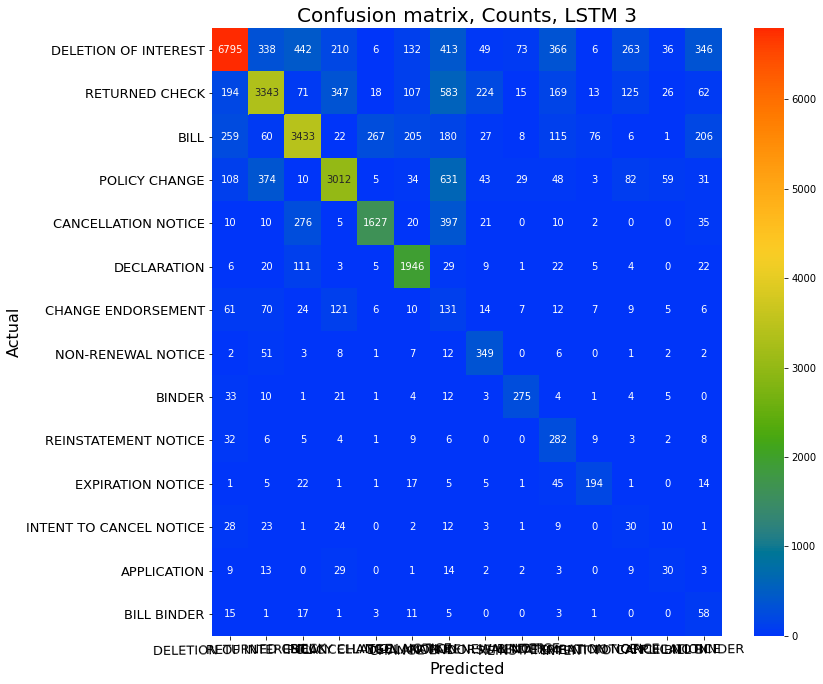

In [122]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ph.plotConfusionMatrix(confusionMat, saveAs=None, xlabels=categories,
                       ylabels=categories, titleText = 'LSTM 3',
                       ax = ax,  xlabelFontSz=labelFontSz,
                       xtickRotate=0.65, ytickRotate=0.0,
                       ylabelFontSz=labelFontSz, xtickFontSz=tickFontSz,
                       ytickFontSz=tickFontSz, titleFontSz=titleFontSz)

##### Plot recall confusion matrix

* normalized by *row*
* diagonal elements now represent the *recall* for each class

fileNameAugmentString:
 Lstm3
Δt:  0.41s.


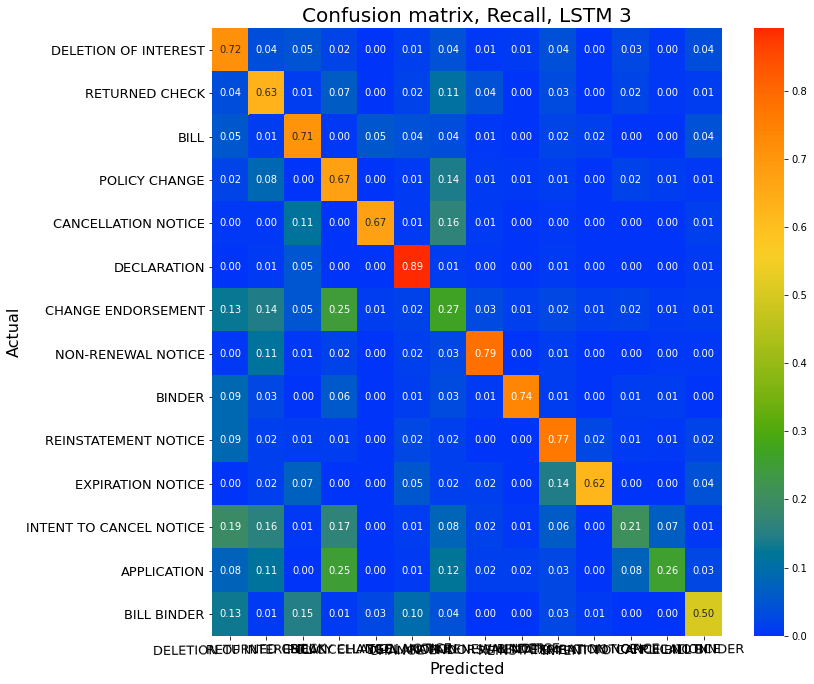

In [123]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ph.plotConfusionMatrix(confusionMat, saveAs=None, xlabels=categories,
                       ylabels=categories, titleText = 'LSTM 3',
                       ax = ax, xlabelFontSz=labelFontSz,
                       xtickRotate=0.65, ytickRotate=0.0, type='recall',
                       ylabelFontSz=labelFontSz, xtickFontSz=tickFontSz,
                       ytickFontSz=tickFontSz, titleFontSz=titleFontSz)

##### Plot precision confusion matrix

* normalized by *column*
* diagonal elements now represent the *precision* for each class

fileNameAugmentString:
 Lstm3
Δt:  0.41s.


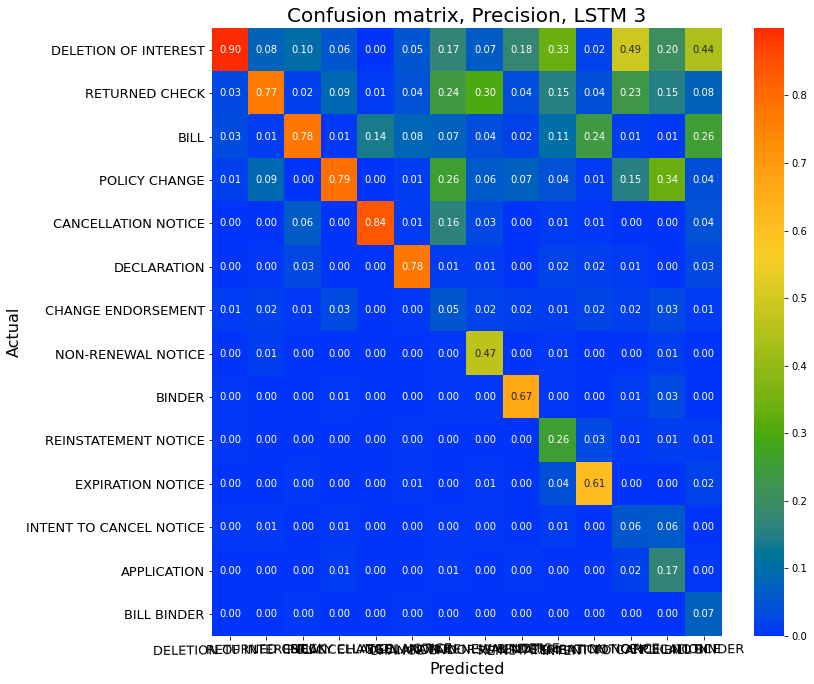

In [124]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ph.plotConfusionMatrix(confusionMat, saveAs=None, xlabels=categories,
                       ylabels=categories, titleText = 'LSTM 3',
                       ax = ax,  xlabelFontSz=labelFontSz,
                       xtickRotate=0.65, ytickRotate=0.0, type='precision',
                       ylabelFontSz=labelFontSz, xtickFontSz=tickFontSz,
                       ytickFontSz=tickFontSz, titleFontSz=titleFontSz)

<a id="tokenize-512-tokens"></a>
### LSTM 4 tokenize

* truncate docs to `maxDocWords = 512` tokens
* pre-pad shorter docs with 0s

##### Tensor of word indices for train

In [125]:
padValue = 0
maxDocWords = 512		# 🢢🢢🢢

XdocsTr = pad_sequences(listOfListsOfWordIndicesTr,
                        maxlen=maxDocWords,
                        dtype='int32', padding='pre',
                        truncating='post', value=padValue)

In [126]:
ListOfDocsTr[0]
print(listOfListsOfWordIndicesTr[0])
XdocsTr[0]

'776d8e8eda28 9d9120c02975 ce015f48ae93 52152b0093a1 5cf416836ddd 21d06acb5c5a 82c32a96c28a fc25f79e6d18 4ef731a80c24 758684f862e4 688c4bbfca80 9e2b31af60e1 c29f0593f229 9c58ed44374f 635ad16e1001 6e2c9c88b447 6ce6cc5a3203 c85b3821556b 89aed7fbfb0e 2e85d01c5d75 e7f10ad56136 2053a6a9efee fb1a3ce496b1 26f768da5068 0a8965c4b8f4 6af770640118 11610fcf8c49 f2b0e028fe2c 72bd4a50cf4a 54709b24b45f 823c39d495d0 6af770640118 6b304aabdcee 335e39009eab cf8a124d4e59 cb7631b88e51 304a68728141 97b6014f9e50 26f768da5068 6af770640118 e137a75c0b90 d5f4611022c1 46c88d9303da d63be9e66da8 4d134e3d5af5 f95d0bea231b 6ce6cc5a3203 6365c4563bd1 6df520735456 6365c4563bd1 6e34c0d3d1aa 6365c4563bd1 46c88d9303da 6365c4563bd1 6365c4563bd1 ff8452befa25 3593bd452331 81dc2e5c1272 d78dc767a475 3689f1b1fc46 ccef80e38b2b f6f466726339 39d83a0aee75 ab399ebcc0fe b9925442c9c9 07b4174549d4 395a5e8185f8 bc5e0615b2da 32f49d072772 53d94d11f6bb 8565203321d4 93977e7acdcf 93790ade6682 eb51798a89e1 9bc65adc033c 97b6014f9e50 26f768da506

[673, 8480, 1911, 1, 29094, 1, 33264, 157, 1395, 399, 6626, 33265, 1, 20636, 4438, 5594, 4, 214, 1327, 73, 204, 17094, 4687, 36, 1, 32, 1, 224, 182, 12, 42966, 32, 21, 10648, 1, 256, 1, 23, 36, 32, 407, 184, 52, 299, 33266, 17, 4, 49, 226, 49, 22415, 49, 52, 49, 49, 943, 1411, 29095, 648, 350, 1, 369, 79132, 726, 723, 568, 265, 4916, 1308, 1, 47871, 1, 44, 63, 33, 23, 36, 32, 36, 7511, 1, 19, 530, 753, 2829, 878, 5595, 21, 35843, 3240, 1170, 73, 153, 9140, 54, 935, 11657, 8722, 1, 2550, 299, 673, 1333, 1, 655, 17095, 5972, 407, 42, 130, 867, 1695, 53, 250, 380, 7, 175, 867, 27, 146, 42, 22416, 1, 3284, 21, 12, 5230, 27, 1, 8481, 1, 31, 177, 655, 42967, 1, 51, 218, 15, 1385, 402, 381, 1, 101, 42, 1, 407, 655, 73, 1, 21, 52, 1029, 17, 6, 326, 122, 577, 5654, 19, 232, 15, 183, 110, 233, 15, 90, 44, 188, 41, 1, 47, 100, 8, 33, 57, 38, 49, 5509, 225, 33, 136, 78, 19, 232, 15, 77, 142, 4500, 39, 655, 82, 34, 25942, 12698, 418, 5509, 225, 12229, 51, 218, 14, 901, 74, 54732, 2, 1199, 67, 12698

array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,

##### Tensor of word indices for test

In [127]:
ListOfDocsTe = list(dfTe.docText)
listOfListsOfWordIndicesTe = tokenizer.texts_to_sequences(ListOfDocsTe)
XdocsTe = pad_sequences(listOfListsOfWordIndicesTe,
                        maxlen=maxDocWords,
                        dtype='int32', padding='pre',
                        truncating='post', value=padValue)

In [128]:
ListOfDocsTe[0]
print(listOfListsOfWordIndicesTe[0])
XdocsTe[0]

'a0c020166d79 133d46f7ed38 fe64d3cdfe5b 36e7aa72ffe1 7a5e719bafba fafeb212675a ff1c26ea0b6f 93c988b67c47 0562c756a2f2 07e7fe209a3b ff714b9fa7fd fe64d3cdfe5b c9a53ea6e219 993ff2804aa9 cbd6e2e7a804 e4c167e314c2 1851758c92b2 e259a56993f4 e94953618947 c79b01c5629d 6ce6cc5a3203 094e2de7e1cd 4ba791167817 9bfc4c4973a6 82204d3e715e 5dc7c49eb85d 2ed97f462806 a51c4e06df28 db3176de6e95 21e314d3afcc 2ee5e18ba524 586242498a88 360e8b28421c df7b799d2534 4a68a8674193 0f88ca127938 9a1d3ab82b96 1e5c095af1d7 71144e880c8d 7d9e333a86da ab876af5ae0b faaa1c06b512 21e314d3afcc e6dbab0cbfb4 5892ad716bb7 d493c688fb66 4ffb12504ac6 e9b0e655984e 347a5d991fe1 0a9b859f7b89 9e851f85cce7 4895c4bdb608 1015893e384a 8f7a92cd0ae7 21e314d3afcc 40fbee1e4d5c 1068682ce752 415fc0f6a895 586242498a88 ac6bf0e47705 21e314d3afcc 09b305bd6c36 664aa24ff74f 427028e08976 11269ab19093 21e314d3afcc becb9d433d2c 327f094890d6 1669ab06727a a263b63bc282 97b6014f9e50 b01c6237ae4a a9ee836e8303 e259a56993f4 ba8f19d976a8 133d46f7ed38 0c4ce226d9f

[71, 9, 118, 53, 209, 8795, 269, 171, 19, 808, 249, 118, 83, 1, 178, 2313, 1188, 135, 232, 218, 4, 1261, 301, 291, 1240, 3305, 372, 1, 1307, 6, 30555, 2, 97, 1037, 647, 286, 707, 4109, 465, 20, 1, 13429, 6, 1233, 366, 125, 128, 7828, 490, 1268, 2177, 7720, 8, 132, 6, 872, 29, 1574, 2, 825, 6, 549, 559, 231, 261, 6, 6289, 579, 244, 574, 23, 1104, 163, 135, 101, 9, 78, 8795, 174, 31526, 1093, 357, 30, 135, 9, 109, 184, 370, 465, 17995, 8790, 787, 6, 218, 1788, 1, 1759, 1991, 266, 787, 2179, 228, 2278, 30, 2201, 494, 2338, 86, 662, 816, 72, 922, 1037, 286, 291, 3305, 4, 3, 165, 1, 353, 23, 367, 8795, 9, 3690, 19, 283, 73, 266, 3, 3283, 122, 165, 209, 269, 2313, 1, 1, 119, 28820, 171, 180, 3, 4165, 80, 9855, 1261, 19, 688, 6, 218, 2, 412, 132, 8795, 16, 19, 78, 132, 871, 78, 132, 14, 1718, 6850, 18129, 208, 37, 943, 1, 4736, 195, 120, 464, 53, 8795, 197, 229, 90, 233, 6, 835, 835, 340, 56, 370, 2, 257, 8, 8795, 2, 149, 13929, 505, 27, 84, 19, 158, 15, 190, 457, 1431, 2378, 409, 743, 3321, 

array([   71,     9,   118,    53,   209,  8795,   269,   171,    19,
         808,   249,   118,    83,     1,   178,  2313,  1188,   135,
         232,   218,     4,  1261,   301,   291,  1240,  3305,   372,
           1,  1307,     6, 30555,     2,    97,  1037,   647,   286,
         707,  4109,   465,    20,     1, 13429,     6,  1233,   366,
         125,   128,  7828,   490,  1268,  2177,  7720,     8,   132,
           6,   872,    29,  1574,     2,   825,     6,   549,   559,
         231,   261,     6,  6289,   579,   244,   574,    23,  1104,
         163,   135,   101,     9,    78,  8795,   174, 31526,  1093,
         357,    30,   135,     9,   109,   184,   370,   465, 17995,
        8790,   787,     6,   218,  1788,     1,  1759,  1991,   266,
         787,  2179,   228,  2278,    30,  2201,   494,  2338,    86,
         662,   816,    72,   922,  1037,   286,   291,  3305,     4,
           3,   165,     1,   353,    23,   367,  8795,     9,  3690,
          19,   283,

<a id="lstm4-parameters"></a>
### LSTM 4

#### baseline model parameters

* Bidirectional(LSTM) only
* `LSTMlayerUnits = 128`
* `maxDocWords = 512`		🢢

Refer to the [LSTM 4](#tokenize-512-tokens) section for the size of `maxVocabCt`.

|parameter|&nbsp;&nbsp;|description|
|:--------|------------|:----------|
|`testFrac`||fraction of data set withheld|
|`LSTMlayerUnits`||# units within each activation unit in LSTMs|
|`embeddingDim'||size of dimension for generated embeddings|
|`auxFeaturesCt`||# of features in auxiliary data|
|`classCt`||# classes (softmax output dim)|
|`dropoutFrac`||dropout fraction|
|`LSTMdropoutFrac`||dropout fraction within LSTMs|
|`batchSz`||size of batches|
|`epochCt`||number of epochs to run|

In [129]:
testFrac = 0.5
LSTMlayerUnits = 128
embeddingDim = 64
classCt = len(categoriesBySupport)
dropoutFrac = 0.15
LSTMdropoutFrac = 0.5
# LSTMdropoutFrac = 0			# Must be 0 for use of cudnn
batchSz = 64
epochCt = 30

#### LSTM 4 callbacks

* checkpoints
* TensorBoard
* (no early stopping)

In [130]:
modelInstanceDir = (f"vocabCt{maxVocabCt:06d}maxCommentLen{maxDocWords:03d}"
                    + f"classCt{classCt:02d}"
                    + f"embedDim{embeddingDim:03d}"
                    + f"LSTMlayerSz{LSTMlayerUnits:03d}batchSz{batchSz:03d}"
                    + f"dropoutFrac{dropoutFrac:4.2f}"
                    + f"LSTMdropoutFrac{dropoutFrac:4.2f}")
print(modelInstanceDir, "\n")

checkpointPrefix = os.path.join(checkpointPath, modelInstanceDir,
                                "ckpt{epoch:03d}")
print(checkpointPrefix, "\n")

checkpointCallback=ModelCheckpoint(filepath=checkpointPrefix,
                                   save_weights_only=True)
os.makedirs(tensorBoardPath, exist_ok=True)                       

logsDir = os.path.join(tensorBoardPath, modelInstanceDir)
print(logsDir, "\n")

os.makedirs(logsDir, exist_ok=True)
tensorboardCallback = TensorBoard(log_dir=logsDir, histogram_freq=1)

vocabCt100000maxCommentLen512classCt14embedDim064LSTMlayerSz128batchSz064dropoutFrac0.15LSTMdropoutFrac0.15 

/home/mark/work/document-classification-test/checkpoints/vocabCt100000maxCommentLen512classCt14embedDim064LSTMlayerSz128batchSz064dropoutFrac0.15LSTMdropoutFrac0.15/ckpt{epoch:03d} 

/home/mark/work/document-classification-test/tensorBoardLogs/vocabCt100000maxCommentLen512classCt14embedDim064LSTMlayerSz128batchSz064dropoutFrac0.15LSTMdropoutFrac0.15 



#### Load or instantiate LSTM 4

In [131]:
LSTM4name = 'LSTM4'

if (modelPath / LSTM4name).is_file():
    print(f"Loading {LSTM4name} model from disk.")
    LSTM4 = load(modelPath / LSTM4name)
else:
    np.random.seed(0)  # Set a random seed for reproducibility

    print("Instantiate LSTM 4, using model0 ...")
    with device('/device:GPU:1'):
        LSTM4 = model0(maxDocWords, maxVocabCt, classCt, LSTMlayerUnits,
                       embeddingDim, softMaxCt=classCt)
    LSTM4.summary()

Instantiate LSTM 4, using model0 ...
Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
MainInput (InputLayer)       [(None, 512)]             0         
_________________________________________________________________
EmbedLayer (Embedding)       (None, 512, 64)           6400000   
_________________________________________________________________
BidrectionalLSTM (Bidirectio (None, 256)               197632    
_________________________________________________________________
Dense0 (Dense)               (None, 64)                16448     
_________________________________________________________________
Dense1 (Dense)               (None, 64)                4160      
_________________________________________________________________
MainOutput (Dense)           (None, 14)                910       
Total params: 6,619,150
Trainable params: 6,619,150
Non-trainable params: 0
____________

#### Compile LSTM 4

In [133]:
if not (modelPath / LSTM4name).is_file():
    with device('/device:GPU:1'):
      LSTM4.compile(optimizer='rmsprop',
                  loss='sparse_categorical_crossentropy',
                  # metrics = ['accuracy', Recall(), Precision(),
                  #            F1Score(num_classes=classCt), 'categorical_crossentropy'])
                  metrics = ['accuracy'])

<a id="train-lstm4"></a>
#### Train LSTM 4

In [134]:
if not (modelPath / LSTM4name).is_file():
    print(epochCt, batchSz)
    print(classWeights)
    with device('/device:GPU:1'):
        history4 = LSTM4.fit(x=XdocsTr,
                             y= yTr.values,
                             epochs=epochCt, batch_size=batchSz,
                             shuffle=True,
                             class_weight=classWeights,
                             validation_split=0.2,
                             callbacks=[checkpointCallback, tensorboardCallback],
                             verbose=1)

30 64
{0: 0.2341198643045609, 1: 0.41878152053723133, 2: 0.456062030075188, 3: 0.4963718313460985, 4: 0.9193061393641584, 5: 1.0156985871271587, 6: 4.592724046140195, 7: 4.984911717495987, 8: 5.9154285714285715, 9: 6.044375243285325, 10: 7.1098901098901095, 11: 15.404761904761905, 12: 19.458646616541355, 13: 19.458646616541355}
Epoch 1/30
389/389 [==============================] - 1006s 3s/step - loss: 2.5213 - accuracy: 0.1141 - val_loss: 1.8972 - val_accuracy: 0.2684
Epoch 2/30
389/389 [==============================] - 980s 3s/step - loss: 1.9046 - accuracy: 0.3221 - val_loss: 1.7374 - val_accuracy: 0.4496
Epoch 3/30
389/389 [==============================] - 974s 3s/step - loss: 1.6006 - accuracy: 0.4771 - val_loss: 1.2133 - val_accuracy: 0.6228
Epoch 4/30
389/389 [==============================] - 977s 3s/step - loss: 1.3383 - accuracy: 0.5955 - val_loss: 1.1630 - val_accuracy: 0.6491
Epoch 5/30
389/389 [==============================] - 983s 3s/step - loss: 1.1582 - accuracy: 0.6

#### Save LSTM 4, if new model

In [135]:
if not (modelPath / LSTM4name).is_file():
    print(f"Saving {LSTM4name} to disk.")
    LSTM4.save(modelPath / LSTM4name)

Saving LSTM4 to disk.
INFO:tensorflow:Assets written to: /home/mark/work/document-classification-test/model/LSTM4/assets


#### LSTM 4 inference on test data

In [136]:
softmaxOut = LSTM4.predict(x=XdocsTe)

In [137]:
yPred = np.argmax(softmaxOut, axis=1)

In [138]:
confusionMat = confusion_matrix(yTe, yPred)
print(confusionMat)

[[7039  273  514  238   22   51  782   25   86  144   29  121   69   82]
 [ 214 3104  255  317   55   78  551  195   42  123  139   91   51   82]
 [ 248  107 3388   23  391  126  129   26    9   35  143    5    2  233]
 [ 164  240   32 2773   14   16  919   40   89   17   11   74   65   15]
 [   4   15  207    6 2057    7   50    7    4    2    2    0    1   51]
 [  21   33   80    4   10 1902   26    5    6   15   36    2    2   41]
 [  47   60   32  106   15    7  168    4   11    5    4    6   11    7]
 [   6   42    9    4    2    1   20  348    1    5    2    1    0    3]
 [  20    9    1   15    2    1   30    2  287    3    1    0    2    1]
 [  33   16   16    1    2    4    5    2    0  241   30    2    1   14]
 [   0    7   21    0    3    3    4    0    0    4  262    0    0    8]
 [  37   19    1   15    2    0   19    2    2    4    0   37    6    0]
 [  12    7    1   29    0    0   31    1    2    0    0    4   28    0]
 [  13    0   21    0    0    3    3    2    0    1

In [139]:
np.where(np.sum(confusionMat, axis=0) == 0)

(array([], dtype=int64),)

In [140]:
accuracy = np.trace(confusionMat)/np.sum(confusionMat)
recall = np.diag(confusionMat)/np.sum(confusionMat, axis=1)
precision = np.diag(confusionMat)/np.sum(confusionMat, axis=0)
print(f"accuracy: {accuracy:0.3f}, "
      f"<precision>: {np.mean(precision):0.3f}, "
      f"<recall>: {np.mean(recall):0.3f}")

accuracy: 0.699, <precision>: 0.510, <recall>: 0.634


##### Classification report

In [141]:
classificationReport = classification_report(yTe.values, yPred,
                                             target_names=[str(c)for c in categoriesBySupport])
print(classificationReport)

                         precision    recall  f1-score   support

                   BILL       0.90      0.74      0.81      9475
          POLICY CHANGE       0.79      0.59      0.67      5297
    CANCELLATION NOTICE       0.74      0.70      0.72      4865
                 BINDER       0.79      0.62      0.69      4469
   DELETION OF INTEREST       0.80      0.85      0.82      2413
   REINSTATEMENT NOTICE       0.86      0.87      0.87      2183
            DECLARATION       0.06      0.35      0.10       483
     CHANGE ENDORSEMENT       0.53      0.78      0.63       444
         RETURNED CHECK       0.53      0.77      0.63       374
      EXPIRATION NOTICE       0.40      0.66      0.50       367
     NON-RENEWAL NOTICE       0.40      0.84      0.54       312
            BILL BINDER       0.11      0.26      0.15       144
            APPLICATION       0.12      0.24      0.16       115
INTENT TO CANCEL NOTICE       0.12      0.62      0.20       115

               accuracy

##### Sorted `classificationReport`

* Order by support

In [142]:
print(ph.sortClassificationReport(classificationReport))

                         precision    recall  f1-score   support

                   BILL       0.90      0.74      0.81      9475
          POLICY CHANGE       0.79      0.59      0.67      5297
    CANCELLATION NOTICE       0.74      0.70      0.72      4865
                 BINDER       0.79      0.62      0.69      4469
   DELETION OF INTEREST       0.80      0.85      0.82      2413
   REINSTATEMENT NOTICE       0.86      0.87      0.87      2183
            DECLARATION       0.06      0.35      0.10       483
     CHANGE ENDORSEMENT       0.53      0.78      0.63       444
         RETURNED CHECK       0.53      0.77      0.63       374
      EXPIRATION NOTICE       0.40      0.66      0.50       367
     NON-RENEWAL NOTICE       0.40      0.84      0.54       312
            BILL BINDER       0.11      0.26      0.15       144
            APPLICATION       0.12      0.24      0.16       115
INTENT TO CANCEL NOTICE       0.12      0.62      0.20       115

               accuracy

##### Plot confusion matrix

* As this is a straight confusion matrix, diagonal elements mostly reflect class size in test set
* *This is hard to interpret by visual inspection alone*

In [143]:
labelFontSz = 16
tickFontSz = 13
titleFontSz = 20

fileNameAugmentString:
 Lstm4
Δt:  0.39s.


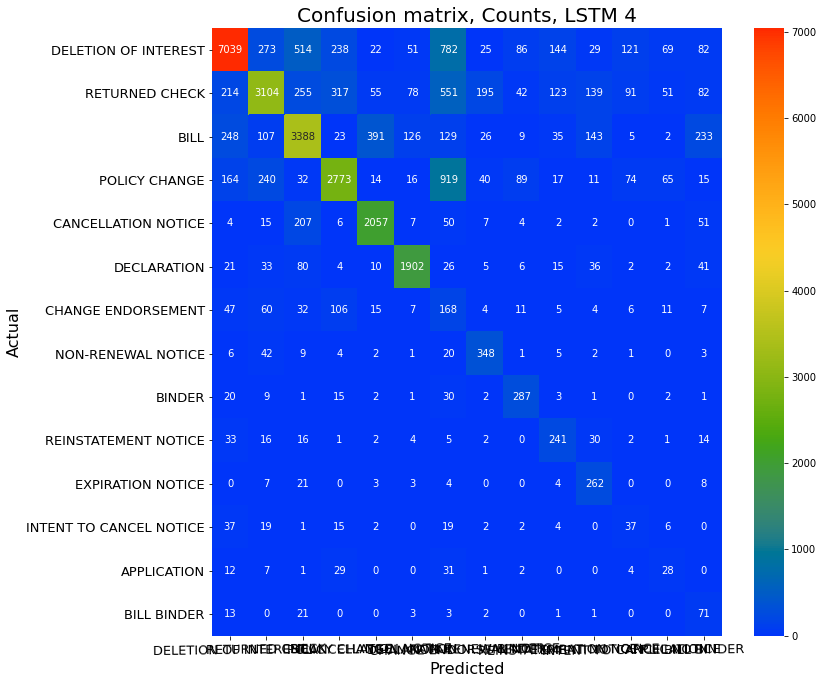

In [144]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ph.plotConfusionMatrix(confusionMat, saveAs=None, xlabels=categories,
                       ylabels=categories, titleText = 'LSTM 4',
                       ax = ax,  xlabelFontSz=labelFontSz,
                       xtickRotate=0.65, ytickRotate=0.0,
                       ylabelFontSz=labelFontSz, xtickFontSz=tickFontSz,
                       ytickFontSz=tickFontSz, titleFontSz=titleFontSz)

##### Plot recall confusion matrix

* normalized by *row*
* diagonal elements now represent the *recall* for each class

fileNameAugmentString:
 Lstm4
Δt:  0.40s.


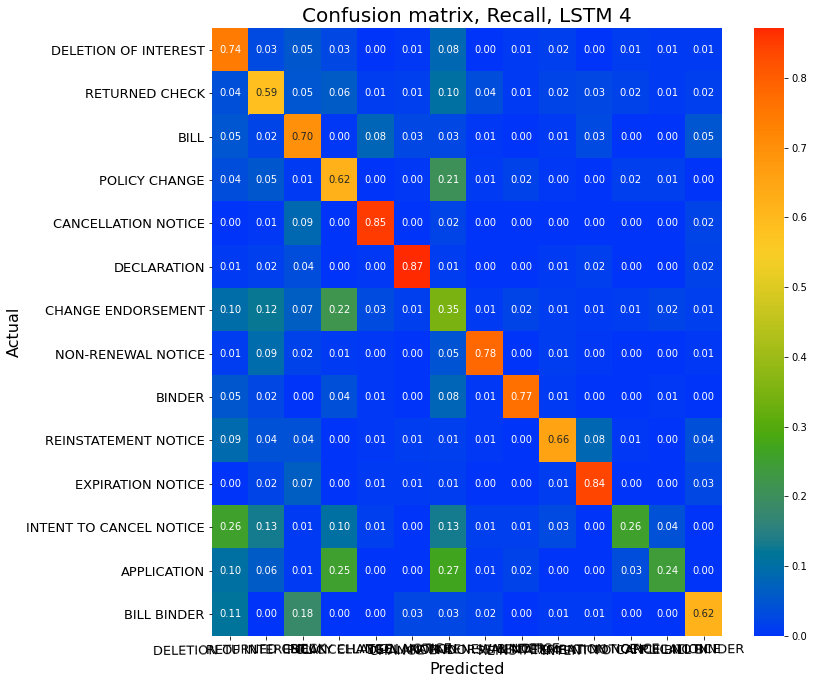

In [145]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ph.plotConfusionMatrix(confusionMat, saveAs=None, xlabels=categories,
                       ylabels=categories, titleText = 'LSTM 4',
                       ax = ax, xlabelFontSz=labelFontSz,
                       xtickRotate=0.65, ytickRotate=0.0, type='recall',
                       ylabelFontSz=labelFontSz, xtickFontSz=tickFontSz,
                       ytickFontSz=tickFontSz, titleFontSz=titleFontSz)

##### Plot precision confusion matrix

* normalized by *column*
* diagonal elements now represent the *precision* for each class

fileNameAugmentString:
 Lstm4
Δt:  0.40s.


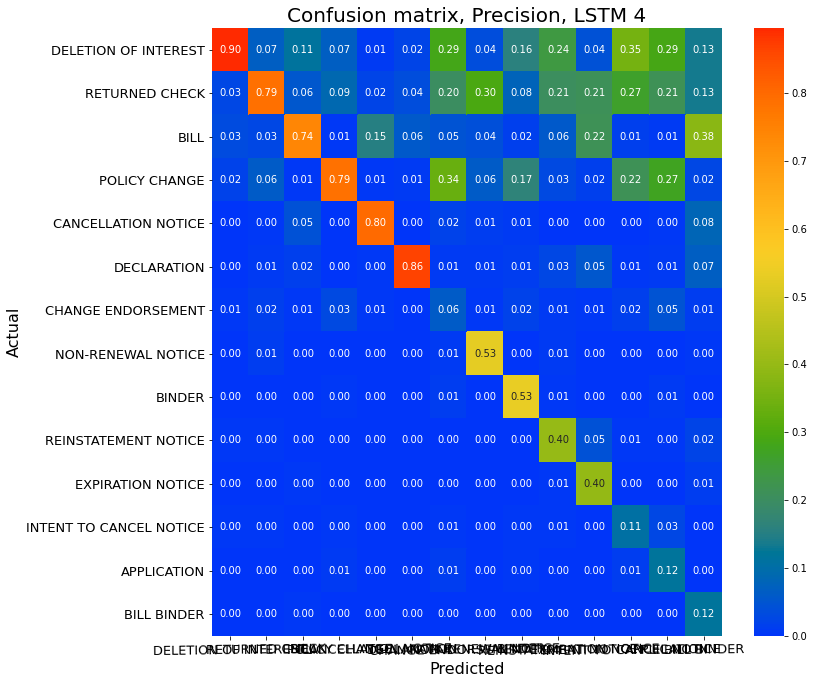

In [146]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ph.plotConfusionMatrix(confusionMat, saveAs=None, xlabels=categories,
                       ylabels=categories, titleText = 'LSTM 4',
                       ax = ax,  xlabelFontSz=labelFontSz,
                       xtickRotate=0.65, ytickRotate=0.0, type='precision',
                       ylabelFontSz=labelFontSz, xtickFontSz=tickFontSz,
                       ytickFontSz=tickFontSz, titleFontSz=titleFontSz)

### Create TensorFlow sentence tokenizer object `maxVocatCt = 200000`

See [helper function `tokenize()`](#helper-tokenize)

Other parameters are defined below in [LSTM 5 model parameters](#lstm5-parameters), and similarly for subsequent models.

Tokenizing takes ~10 s.

In [182]:
maxVocabCt = 200_000

In [183]:
ListOfDocsTr = list(dfTr.docText)
listOfListsOfWordIndicesTr, tokenizer = tokenize(ListOfDocsTr, maxVocabCt)

<a id="tokenize-256-tokens-maxvocabct-200000"></a>
### LSTM 5 tokenize, `maxVocabCt = 200000`

* truncate docs to `maxDocWords = 256` tokens
* pre-pad shorter docs with 0s

##### Tensor of word indices for train

In [184]:
padValue = 0
maxDocWords = 256		# 🢢🢢🢢 (reverting to shorter documents)

XdocsTr = pad_sequences(listOfListsOfWordIndicesTr,
                        maxlen=maxDocWords,
                        dtype='int32', padding='pre',
                        truncating='post', value=padValue)

In [185]:
ListOfDocsTr[0]
print(listOfListsOfWordIndicesTr[0])
XdocsTr[0]

'776d8e8eda28 9d9120c02975 ce015f48ae93 52152b0093a1 5cf416836ddd 21d06acb5c5a 82c32a96c28a fc25f79e6d18 4ef731a80c24 758684f862e4 688c4bbfca80 9e2b31af60e1 c29f0593f229 9c58ed44374f 635ad16e1001 6e2c9c88b447 6ce6cc5a3203 c85b3821556b 89aed7fbfb0e 2e85d01c5d75 e7f10ad56136 2053a6a9efee fb1a3ce496b1 26f768da5068 0a8965c4b8f4 6af770640118 11610fcf8c49 f2b0e028fe2c 72bd4a50cf4a 54709b24b45f 823c39d495d0 6af770640118 6b304aabdcee 335e39009eab cf8a124d4e59 cb7631b88e51 304a68728141 97b6014f9e50 26f768da5068 6af770640118 e137a75c0b90 d5f4611022c1 46c88d9303da d63be9e66da8 4d134e3d5af5 f95d0bea231b 6ce6cc5a3203 6365c4563bd1 6df520735456 6365c4563bd1 6e34c0d3d1aa 6365c4563bd1 46c88d9303da 6365c4563bd1 6365c4563bd1 ff8452befa25 3593bd452331 81dc2e5c1272 d78dc767a475 3689f1b1fc46 ccef80e38b2b f6f466726339 39d83a0aee75 ab399ebcc0fe b9925442c9c9 07b4174549d4 395a5e8185f8 bc5e0615b2da 32f49d072772 53d94d11f6bb 8565203321d4 93977e7acdcf 93790ade6682 eb51798a89e1 9bc65adc033c 97b6014f9e50 26f768da506

[673, 8480, 1911, 176125, 29094, 176126, 33264, 157, 1395, 399, 6626, 33265, 104525, 20636, 4438, 5594, 4, 214, 1327, 73, 204, 17094, 4687, 36, 176127, 32, 176128, 224, 182, 12, 42966, 32, 21, 10648, 176129, 256, 104526, 23, 36, 32, 407, 184, 52, 299, 33266, 17, 4, 49, 226, 49, 22415, 49, 52, 49, 49, 943, 1411, 29095, 648, 350, 104527, 369, 79132, 726, 723, 568, 265, 4916, 1308, 176130, 47871, 176131, 44, 63, 33, 23, 36, 32, 36, 7511, 176132, 19, 530, 753, 2829, 878, 5595, 21, 35843, 3240, 1170, 73, 153, 9140, 54, 935, 11657, 8722, 176133, 2550, 299, 673, 1333, 176134, 655, 17095, 5972, 407, 42, 130, 867, 1695, 53, 250, 380, 7, 175, 867, 27, 146, 42, 22416, 104528, 3284, 21, 12, 5230, 27, 104528, 8481, 176135, 31, 177, 655, 42967, 104529, 51, 218, 15, 1385, 402, 381, 176136, 101, 42, 176137, 407, 655, 73, 176138, 21, 52, 1029, 17, 6, 326, 122, 577, 5654, 19, 232, 15, 183, 110, 233, 15, 90, 44, 188, 41, 104529, 47, 100, 8, 33, 57, 38, 49, 5509, 225, 33, 136, 78, 19, 232, 15, 77, 142, 45

array([   673,   8480,   1911, 176125,  29094, 176126,  33264,    157,
         1395,    399,   6626,  33265, 104525,  20636,   4438,   5594,
            4,    214,   1327,     73,    204,  17094,   4687,     36,
       176127,     32, 176128,    224,    182,     12,  42966,     32,
           21,  10648, 176129,    256, 104526,     23,     36,     32,
          407,    184,     52,    299,  33266,     17,      4,     49,
          226,     49,  22415,     49,     52,     49,     49,    943,
         1411,  29095,    648,    350, 104527,    369,  79132,    726,
          723,    568,    265,   4916,   1308, 176130,  47871, 176131,
           44,     63,     33,     23,     36,     32,     36,   7511,
       176132,     19,    530,    753,   2829,    878,   5595,     21,
        35843,   3240,   1170,     73,    153,   9140,     54,    935,
        11657,   8722, 176133,   2550,    299,    673,   1333, 176134,
          655,  17095,   5972,    407,     42,    130,    867,   1695,
      

##### Tensor of word indices for test

In [186]:
ListOfDocsTe = list(dfTe.docText)
listOfListsOfWordIndicesTe = tokenizer.texts_to_sequences(ListOfDocsTe)
XdocsTe = pad_sequences(listOfListsOfWordIndicesTe,
                        maxlen=maxDocWords,
                        dtype='int32', padding='pre',
                        truncating='post', value=padValue)

In [187]:
ListOfDocsTe[0]
print(listOfListsOfWordIndicesTe[0])
XdocsTe[0]

'a0c020166d79 133d46f7ed38 fe64d3cdfe5b 36e7aa72ffe1 7a5e719bafba fafeb212675a ff1c26ea0b6f 93c988b67c47 0562c756a2f2 07e7fe209a3b ff714b9fa7fd fe64d3cdfe5b c9a53ea6e219 993ff2804aa9 cbd6e2e7a804 e4c167e314c2 1851758c92b2 e259a56993f4 e94953618947 c79b01c5629d 6ce6cc5a3203 094e2de7e1cd 4ba791167817 9bfc4c4973a6 82204d3e715e 5dc7c49eb85d 2ed97f462806 a51c4e06df28 db3176de6e95 21e314d3afcc 2ee5e18ba524 586242498a88 360e8b28421c df7b799d2534 4a68a8674193 0f88ca127938 9a1d3ab82b96 1e5c095af1d7 71144e880c8d 7d9e333a86da ab876af5ae0b faaa1c06b512 21e314d3afcc e6dbab0cbfb4 5892ad716bb7 d493c688fb66 4ffb12504ac6 e9b0e655984e 347a5d991fe1 0a9b859f7b89 9e851f85cce7 4895c4bdb608 1015893e384a 8f7a92cd0ae7 21e314d3afcc 40fbee1e4d5c 1068682ce752 415fc0f6a895 586242498a88 ac6bf0e47705 21e314d3afcc 09b305bd6c36 664aa24ff74f 427028e08976 11269ab19093 21e314d3afcc becb9d433d2c 327f094890d6 1669ab06727a a263b63bc282 97b6014f9e50 b01c6237ae4a a9ee836e8303 e259a56993f4 ba8f19d976a8 133d46f7ed38 0c4ce226d9f

[71, 9, 118, 53, 209, 8795, 269, 171, 19, 808, 249, 118, 83, 1, 178, 2313, 1188, 135, 232, 218, 4, 1261, 301, 291, 1240, 3305, 372, 1, 1307, 6, 30555, 2, 97, 1037, 647, 286, 707, 4109, 465, 20, 1, 13429, 6, 1233, 366, 125, 128, 7828, 490, 1268, 2177, 7720, 8, 132, 6, 872, 29, 1574, 2, 825, 6, 549, 559, 231, 261, 6, 6289, 579, 244, 574, 23, 1104, 163, 135, 101, 9, 78, 8795, 174, 31526, 1093, 357, 30, 135, 9, 109, 184, 370, 465, 17995, 8790, 787, 6, 218, 1788, 141375, 1759, 1991, 266, 787, 2179, 228, 2278, 30, 2201, 494, 2338, 86, 662, 816, 72, 922, 1037, 286, 291, 3305, 4, 3, 165, 1, 353, 23, 367, 8795, 9, 3690, 19, 283, 73, 266, 3, 3283, 122, 165, 209, 269, 2313, 1, 1, 119, 28820, 171, 180, 3, 4165, 80, 9855, 1261, 19, 688, 6, 218, 2, 412, 132, 8795, 16, 19, 78, 132, 871, 78, 132, 14, 1718, 6850, 18129, 208, 37, 943, 1, 4736, 195, 120, 464, 53, 8795, 197, 229, 90, 233, 6, 835, 835, 340, 56, 370, 2, 257, 8, 8795, 2, 149, 13929, 505, 27, 84, 19, 158, 15, 190, 457, 1431, 2378, 409, 743, 3

array([    71,      9,    118,     53,    209,   8795,    269,    171,
           19,    808,    249,    118,     83,      1,    178,   2313,
         1188,    135,    232,    218,      4,   1261,    301,    291,
         1240,   3305,    372,      1,   1307,      6,  30555,      2,
           97,   1037,    647,    286,    707,   4109,    465,     20,
            1,  13429,      6,   1233,    366,    125,    128,   7828,
          490,   1268,   2177,   7720,      8,    132,      6,    872,
           29,   1574,      2,    825,      6,    549,    559,    231,
          261,      6,   6289,    579,    244,    574,     23,   1104,
          163,    135,    101,      9,     78,   8795,    174,  31526,
         1093,    357,     30,    135,      9,    109,    184,    370,
          465,  17995,   8790,    787,      6,    218,   1788, 141375,
         1759,   1991,    266,    787,   2179,    228,   2278,     30,
         2201,    494,   2338,     86,    662,    816,     72,    922,
      

<a id="lstm5-parameters"></a>
### LSTM 5, baseline model parameters

* Bidirectional(LSTM) only
* `LSTMlayerUnits = 128`
* `maxDocWords = 256`		🢢

Refer to the [LSTM 5 tokenize, `maxVocabCt = 200000`](#tokenize-256-tokens-maxvocabct-200000) section for the size of `maxVocabCt`.

|parameter|&nbsp;&nbsp;|description|
|:--------|------------|:----------|
|`testFrac`||fraction of data set withheld|
|`LSTMlayerUnits`||# units within each activation unit in LSTMs|
|`embeddingDim'||size of dimension for generated embeddings|
|`auxFeaturesCt`||# of features in auxiliary data|
|`classCt`||# classes (softmax output dim)|
|`dropoutFrac`||dropout fraction|
|`LSTMdropoutFrac`||dropout fraction within LSTMs|
|`batchSz`||size of batches|
|`epochCt`||number of epochs to run|

In [188]:
testFrac = 0.5
LSTMlayerUnits = 128
embeddingDim = 64
classCt = len(categoriesBySupport)
dropoutFrac = 0.15
LSTMdropoutFrac = 0.5
# LSTMdropoutFrac = 0			# Must be 0 for use of cudnn
batchSz = 64
epochCt = 30

#### Save space

In [181]:
del LSTM4

#### LSTM 5 callbacks

* checkpoints
* TensorBoard
* (no early stopping)

In [189]:
modelInstanceDir = (f"vocabCt{maxVocabCt:06d}maxCommentLen{maxDocWords:03d}"
                    + f"classCt{classCt:02d}"
                    + f"embedDim{embeddingDim:03d}"
                    + f"LSTMlayerSz{LSTMlayerUnits:03d}batchSz{batchSz:03d}"
                    + f"dropoutFrac{dropoutFrac:4.2f}"
                    + f"LSTMdropoutFrac{dropoutFrac:4.2f}")
print(modelInstanceDir, "\n")

checkpointPrefix = os.path.join(checkpointPath, modelInstanceDir,
                                "ckpt{epoch:03d}")
print(checkpointPrefix, "\n")

checkpointCallback=ModelCheckpoint(filepath=checkpointPrefix,
                                   save_weights_only=True)
os.makedirs(tensorBoardPath, exist_ok=True)                       

logsDir = os.path.join(tensorBoardPath, modelInstanceDir)
print(logsDir, "\n")

os.makedirs(logsDir, exist_ok=True)
tensorboardCallback = TensorBoard(log_dir=logsDir, histogram_freq=1)

vocabCt200000maxCommentLen256classCt14embedDim064LSTMlayerSz128batchSz064dropoutFrac0.15LSTMdropoutFrac0.15 

/home/mark/work/document-classification-test/checkpoints/vocabCt200000maxCommentLen256classCt14embedDim064LSTMlayerSz128batchSz064dropoutFrac0.15LSTMdropoutFrac0.15/ckpt{epoch:03d} 

/home/mark/work/document-classification-test/tensorBoardLogs/vocabCt200000maxCommentLen256classCt14embedDim064LSTMlayerSz128batchSz064dropoutFrac0.15LSTMdropoutFrac0.15 



#### Load or instantiate LSTM 5

In [190]:
LSTM5name = 'LSTM5'

if (modelPath / LSTM5name).is_file():
    print(f"Loading {LSTM5name} model from disk.")
    LSTM5 = load(modelPath / LSTM5name)
else:
    np.random.seed(0)  # Set a random seed for reproducibility

    print("Instantiate LSTM 5, using model0 ...")
    with device('/device:GPU:1'):
        LSTM5 = model0(maxDocWords, maxVocabCt, classCt, LSTMlayerUnits,
                       embeddingDim, softMaxCt=classCt)
    LSTM5.summary()

Instantiate LSTM 5, using model0 ...
Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
MainInput (InputLayer)       [(None, 256)]             0         
_________________________________________________________________
EmbedLayer (Embedding)       (None, 256, 64)           12800000  
_________________________________________________________________
BidrectionalLSTM (Bidirectio (None, 256)               197632    
_________________________________________________________________
Dense0 (Dense)               (None, 64)                16448     
_________________________________________________________________
Dense1 (Dense)               (None, 64)                4160      
_________________________________________________________________
MainOutput (Dense)           (None, 14)                910       
Total params: 13,019,150
Trainable params: 13,019,150
Non-trainable params: 0
__________

#### Compile LSTM 5

In [191]:
if not (modelPath / LSTM5name).is_file():
    with device('/device:GPU:1'):
      LSTM5.compile(optimizer='rmsprop',
                  loss='sparse_categorical_crossentropy',
                  # metrics = ['accuracy', Recall(), Precision(),
                  #            F1Score(num_classes=classCt), 'categorical_crossentropy'])
                  metrics = ['accuracy', SparseCategoricalCrossentropy(from_logits=False)])

<a id="train-lstm5"></a>
#### Train LSTM 5

In [192]:
if not (modelPath / LSTM5name).is_file():
    print(epochCt, batchSz)
    print(classWeights)
    with device('/device:GPU:1'):
        history5 = LSTM5.fit(x=XdocsTr,
                             y= yTr.values,
                             epochs=epochCt, batch_size=batchSz,
                             shuffle=True,
                             class_weight=classWeights,
                             validation_split=0.2,
                             callbacks=[checkpointCallback, tensorboardCallback],
                             verbose=1)

30 64
{0: 0.2341198643045609, 1: 0.41878152053723133, 2: 0.456062030075188, 3: 0.4963718313460985, 4: 0.9193061393641584, 5: 1.0156985871271587, 6: 4.592724046140195, 7: 4.984911717495987, 8: 5.9154285714285715, 9: 6.044375243285325, 10: 7.1098901098901095, 11: 15.404761904761905, 12: 19.458646616541355, 13: 19.458646616541355}
Epoch 1/30
389/389 [==============================] - 506s 1s/step - loss: 2.3943 - accuracy: 0.2027 - sparse_categorical_crossentropy: 2.3509 - val_loss: 1.7033 - val_accuracy: 0.4940 - val_sparse_categorical_crossentropy: 1.7033
Epoch 2/30
389/389 [==============================] - 487s 1s/step - loss: 1.7634 - accuracy: 0.4908 - sparse_categorical_crossentropy: 1.6044 - val_loss: 2.0094 - val_accuracy: 0.2307 - val_sparse_categorical_crossentropy: 2.0094
Epoch 3/30
389/389 [==============================] - 486s 1s/step - loss: 1.4431 - accuracy: 0.5595 - sparse_categorical_crossentropy: 1.3575 - val_loss: 1.0944 - val_accuracy: 0.6824 - val_sparse_categorica

#### Save LSTM 5, if new model

In [193]:
if not (modelPath / LSTM5name).is_file():
    print(f"Saving {LSTM5name} to disk.")
    LSTM5.save(modelPath / LSTM5name)

Saving LSTM5 to disk.
INFO:tensorflow:Assets written to: /home/mark/work/document-classification-test/model/LSTM5/assets


#### LSTM 5 inference on test data

In [194]:
softmaxOut = LSTM5.predict(x=XdocsTe)

In [195]:
yPred = np.argmax(softmaxOut, axis=1)

In [196]:
confusionMat = confusion_matrix(yTe, yPred)
print(confusionMat)

[[6811  302  695  490   11   46  440    3  147   36    8  327   42  117]
 [ 166 3329  206  700   39   30  458  100   28   48   45   75   48   25]
 [ 239   80 3703   39  408   73  199    1   20   11   25    3    4   60]
 [  78  253   29 3638    3    2  342    9   31    1    1   38   37    7]
 [   3    9  220    8 2112    5   50    2    2    1    0    0    0    1]
 [  18   30  238   10   15 1766   46    1    2   11    7    0    0   39]
 [  49   61   33  192   15    6   93    1   12    0    3    8    9    1]
 [   3   36    8   16    8    0   23  345    0    3    0    1    1    0]
 [  23    8    8   40    0    0   26    0  262    1    1    3    1    1]
 [  56   17   39    4    4   18   15    0    0  170   27    5    0   12]
 [   5    7   71    0    3    8    5    0    0    8  199    0    1    5]
 [  25   24    3   42    0    1    7    0    3    1    0   30    7    1]
 [   6   17    2   45    0    1    7    0    1    0    0    3   33    0]
 [  16    1   41    1    3    1    8    0    0    1

In [197]:
np.where(np.sum(confusionMat, axis=0) == 0)

(array([], dtype=int64),)

In [198]:
accuracy = np.trace(confusionMat)/np.sum(confusionMat)
recall = np.diag(confusionMat)/np.sum(confusionMat, axis=1)
precision = np.diag(confusionMat)/np.sum(confusionMat, axis=0)
print(f"accuracy: {accuracy:0.3f}, "
      f"<precision>: {np.mean(precision):0.3f}, "
      f"<recall>: {np.mean(recall):0.3f}")

accuracy: 0.726, <precision>: 0.551, <recall>: 0.588


##### Classification report

In [199]:
classificationReport = classification_report(yTe.values, yPred,
                                             target_names=[str(c)for c in categoriesBySupport])
print(classificationReport)

                         precision    recall  f1-score   support

                   BILL       0.91      0.72      0.80      9475
          POLICY CHANGE       0.80      0.63      0.70      5297
    CANCELLATION NOTICE       0.70      0.76      0.73      4865
                 BINDER       0.70      0.81      0.75      4469
   DELETION OF INTEREST       0.81      0.88      0.84      2413
   REINSTATEMENT NOTICE       0.90      0.81      0.85      2183
            DECLARATION       0.05      0.19      0.08       483
     CHANGE ENDORSEMENT       0.75      0.78      0.76       444
         RETURNED CHECK       0.52      0.70      0.59       374
      EXPIRATION NOTICE       0.58      0.46      0.52       367
     NON-RENEWAL NOTICE       0.63      0.64      0.63       312
            BILL BINDER       0.06      0.21      0.09       144
            APPLICATION       0.18      0.29      0.22       115
INTENT TO CANCEL NOTICE       0.14      0.37      0.20       115

               accuracy

##### Sorted `classificationReport`

* Order by support

In [200]:
print(ph.sortClassificationReport(classificationReport))

                         precision    recall  f1-score   support

                   BILL       0.91      0.72      0.80      9475
          POLICY CHANGE       0.80      0.63      0.70      5297
    CANCELLATION NOTICE       0.70      0.76      0.73      4865
                 BINDER       0.70      0.81      0.75      4469
   DELETION OF INTEREST       0.81      0.88      0.84      2413
   REINSTATEMENT NOTICE       0.90      0.81      0.85      2183
            DECLARATION       0.05      0.19      0.08       483
     CHANGE ENDORSEMENT       0.75      0.78      0.76       444
         RETURNED CHECK       0.52      0.70      0.59       374
      EXPIRATION NOTICE       0.58      0.46      0.52       367
     NON-RENEWAL NOTICE       0.63      0.64      0.63       312
            BILL BINDER       0.06      0.21      0.09       144
            APPLICATION       0.18      0.29      0.22       115
INTENT TO CANCEL NOTICE       0.14      0.37      0.20       115

               accuracy

##### Plot confusion matrix

* As this is a straight confusion matrix, diagonal elements mostly reflect class size in test set
* *This is hard to interpret by visual inspection alone*

In [201]:
labelFontSz = 16
tickFontSz = 13
titleFontSz = 20

fileNameAugmentString:
 Lstm3
Δt:  0.38s.


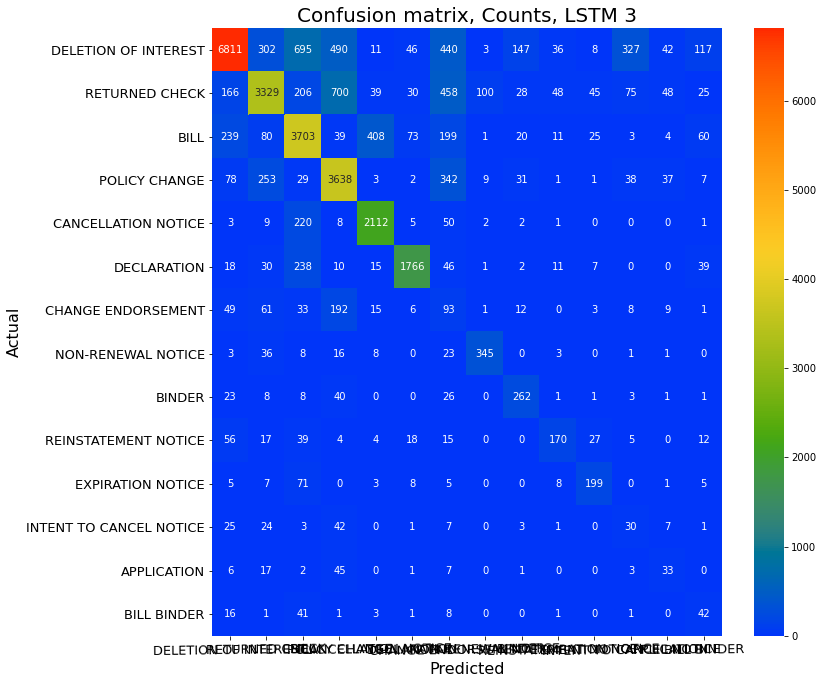

In [202]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ph.plotConfusionMatrix(confusionMat, saveAs=None, xlabels=categories,
                       ylabels=categories, titleText = 'LSTM 3',
                       ax = ax,  xlabelFontSz=labelFontSz,
                       xtickRotate=0.65, ytickRotate=0.0,
                       ylabelFontSz=labelFontSz, xtickFontSz=tickFontSz,
                       ytickFontSz=tickFontSz, titleFontSz=titleFontSz)

##### Plot recall confusion matrix

* normalized by *row*
* diagonal elements now represent the *recall* for each class

fileNameAugmentString:
 Lstm3
Δt:  0.40s.


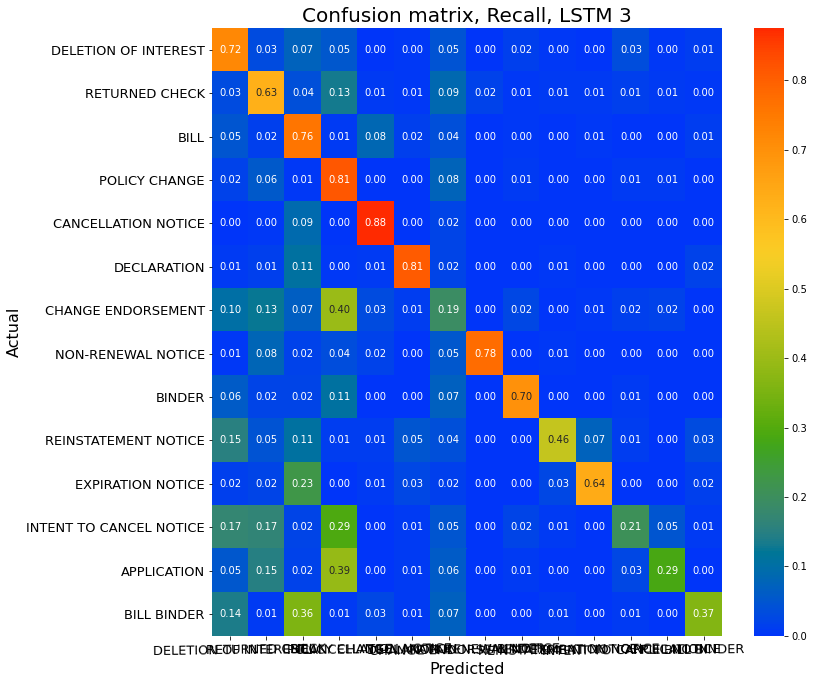

In [203]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ph.plotConfusionMatrix(confusionMat, saveAs=None, xlabels=categories,
                       ylabels=categories, titleText = 'LSTM 3',
                       ax = ax, xlabelFontSz=labelFontSz,
                       xtickRotate=0.65, ytickRotate=0.0, type='recall',
                       ylabelFontSz=labelFontSz, xtickFontSz=tickFontSz,
                       ytickFontSz=tickFontSz, titleFontSz=titleFontSz)

##### Plot precision confusion matrix

* normalized by *column*
* diagonal elements now represent the *precision* for each class

fileNameAugmentString:
 Lstm3
Δt:  0.39s.


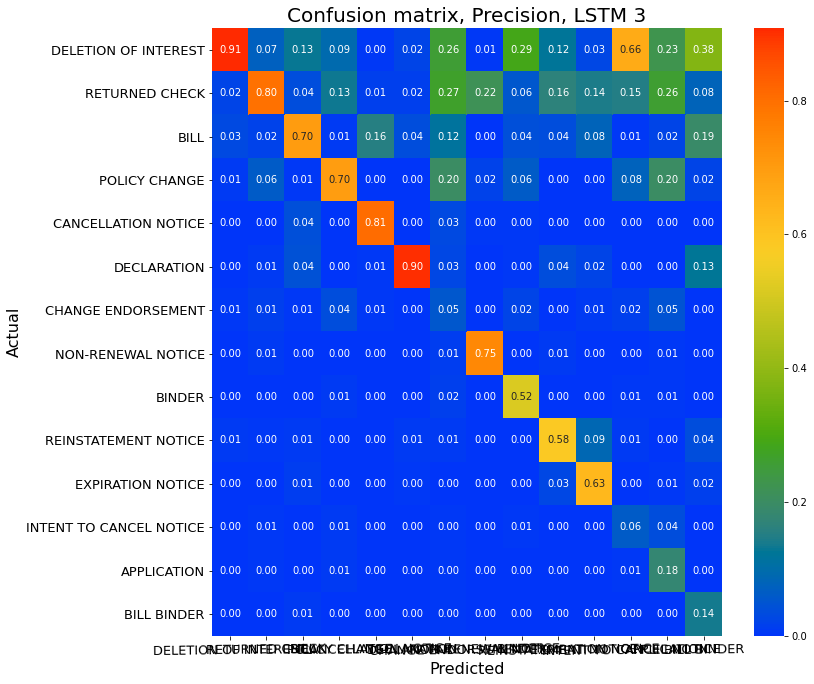

In [204]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ph.plotConfusionMatrix(confusionMat, saveAs=None, xlabels=categories,
                       ylabels=categories, titleText = 'LSTM 3',
                       ax = ax,  xlabelFontSz=labelFontSz,
                       xtickRotate=0.65, ytickRotate=0.0, type='precision',
                       ylabelFontSz=labelFontSz, xtickFontSz=tickFontSz,
                       ytickFontSz=tickFontSz, titleFontSz=titleFontSz)